In [1]:
# @title
!pip install feature-engine
!pip install holidays keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 2.4 MB/s eta 0:00:00a 0:00:01m


In [2]:
# @title
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-16 19:15:55.791513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 19:15:55.791615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 19:15:55.986323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_excel("/kaggle/input/demand-forecasting-dataset/dataset.xlsx")
df

Unnamed: 0       date  sales
0              0 2013-01-01     13
1              1 2013-01-02     11
2              2 2013-01-03     14
3              3 2013-01-04     13
4              4 2013-01-05     10
...          ...        ...    ...
1821        1821 2017-12-27     14
1822        1822 2017-12-28     19
1823        1823 2017-12-29     15
1824        1824 2017-12-30     27
1825        1825 2017-12-31     23

[1826 rows x 3 columns]

In [4]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [5]:
date_time = pd.DataFrame(df['date'])

In [6]:
df['date'] = df['date'].astype(str) + ' 00:00:00'

In [7]:
df.head()

date  sales
0  2013-01-01 00:00:00     13
1  2013-01-02 00:00:00     11
2  2013-01-03 00:00:00     14
3  2013-01-04 00:00:00     13
4  2013-01-05 00:00:00     10

In [8]:
df.describe().transpose()

count       mean       std  min   25%   50%   75%   max
sales  1826.0  19.971522  6.741022  4.0  15.0  19.0  24.0  50.0

In [9]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [10]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and converts it to signal (sine and cosine) to deal with periodicity.
    Input:
        df: DataFrame with a DateTime index
    Output:
        df: DataFrame with additional columns representing Sin/Cosine signals for timestamp, month, day, week, and year
    '''
    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24 * 60 * 60
    week = 7 * day
    year = 365.2425 * day

    # Extract month and day components
    df['Month'] = df.index.month
    df['Day_of_month'] = df.index.day

    # Apply cyclical features transformer to month and day columns
    cyclical_transformer = CyclicalFeatures(
        variables=['Month', 'Day_of_month'],  # specify the variable to transform
        drop_original=True  # drop the original variables
    )

    df = cyclical_transformer.fit_transform(df)

    df['Week sin'] = np.sin(2 * np.pi * timestamp_s / week)
    df['Week cos'] = np.cos(2 * np.pi * timestamp_s / week)

    df['Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

    return df



In [11]:
df = dateTimeToSignal(df)

In [12]:
df

sales     Month_sin  Month_cos  Day_of_month_sin  \
date                                                           
2013-01-01     13  5.000000e-01   0.866025      2.012985e-01   
2013-01-02     11  5.000000e-01   0.866025      3.943559e-01   
2013-01-03     14  5.000000e-01   0.866025      5.712682e-01   
2013-01-04     13  5.000000e-01   0.866025      7.247928e-01   
2013-01-05     10  5.000000e-01   0.866025      8.486443e-01   
...           ...           ...        ...               ...   
2017-12-27     14 -2.449294e-16   1.000000     -7.247928e-01   
2017-12-28     19 -2.449294e-16   1.000000     -5.712682e-01   
2017-12-29     15 -2.449294e-16   1.000000     -3.943559e-01   
2017-12-30     27 -2.449294e-16   1.000000     -2.012985e-01   
2017-12-31     23 -2.449294e-16   1.000000     -2.449294e-16   

            Day_of_month_cos      Week sin  Week cos  Year sin  Year cos  
date                                                                      
2013-01-01          0.979530 -9.749279e-01 -0.222521  0.009848  0.999952  
2013-01-02          0.918958 -7.818315e-01  0.623490  0.027048  0.999634  
2013-01-03          0.820763 -1.801393e-13  1.000000  0.044240  0.999021  
2013-01-04          0.688967  7.818315e-01  0.623490  0.061418  0.998112  
2013-01-05          0.528964  9.749279e-01 -0.222521  0.078579  0.996908  
...                      ...           ...       ...       ...       ...  
2017-12-27          0.688967 -7.818315e-01  0.623490 -0.079736  0.996816  
2017-12-28          0.820763  5.804087e-13  1.000000 -0.062577  0.998040  
2017-12-29          0.918958  7.818315e-01  0.623490 -0.045400  0.998969  
2017-12-30          0.979530  9.749279e-01 -0.222521 -0.028209  0.999602  
2017-12-31          1.000000  4.338837e-01 -0.900969 -0.011010  0.999939  

[1826 rows x 9 columns]

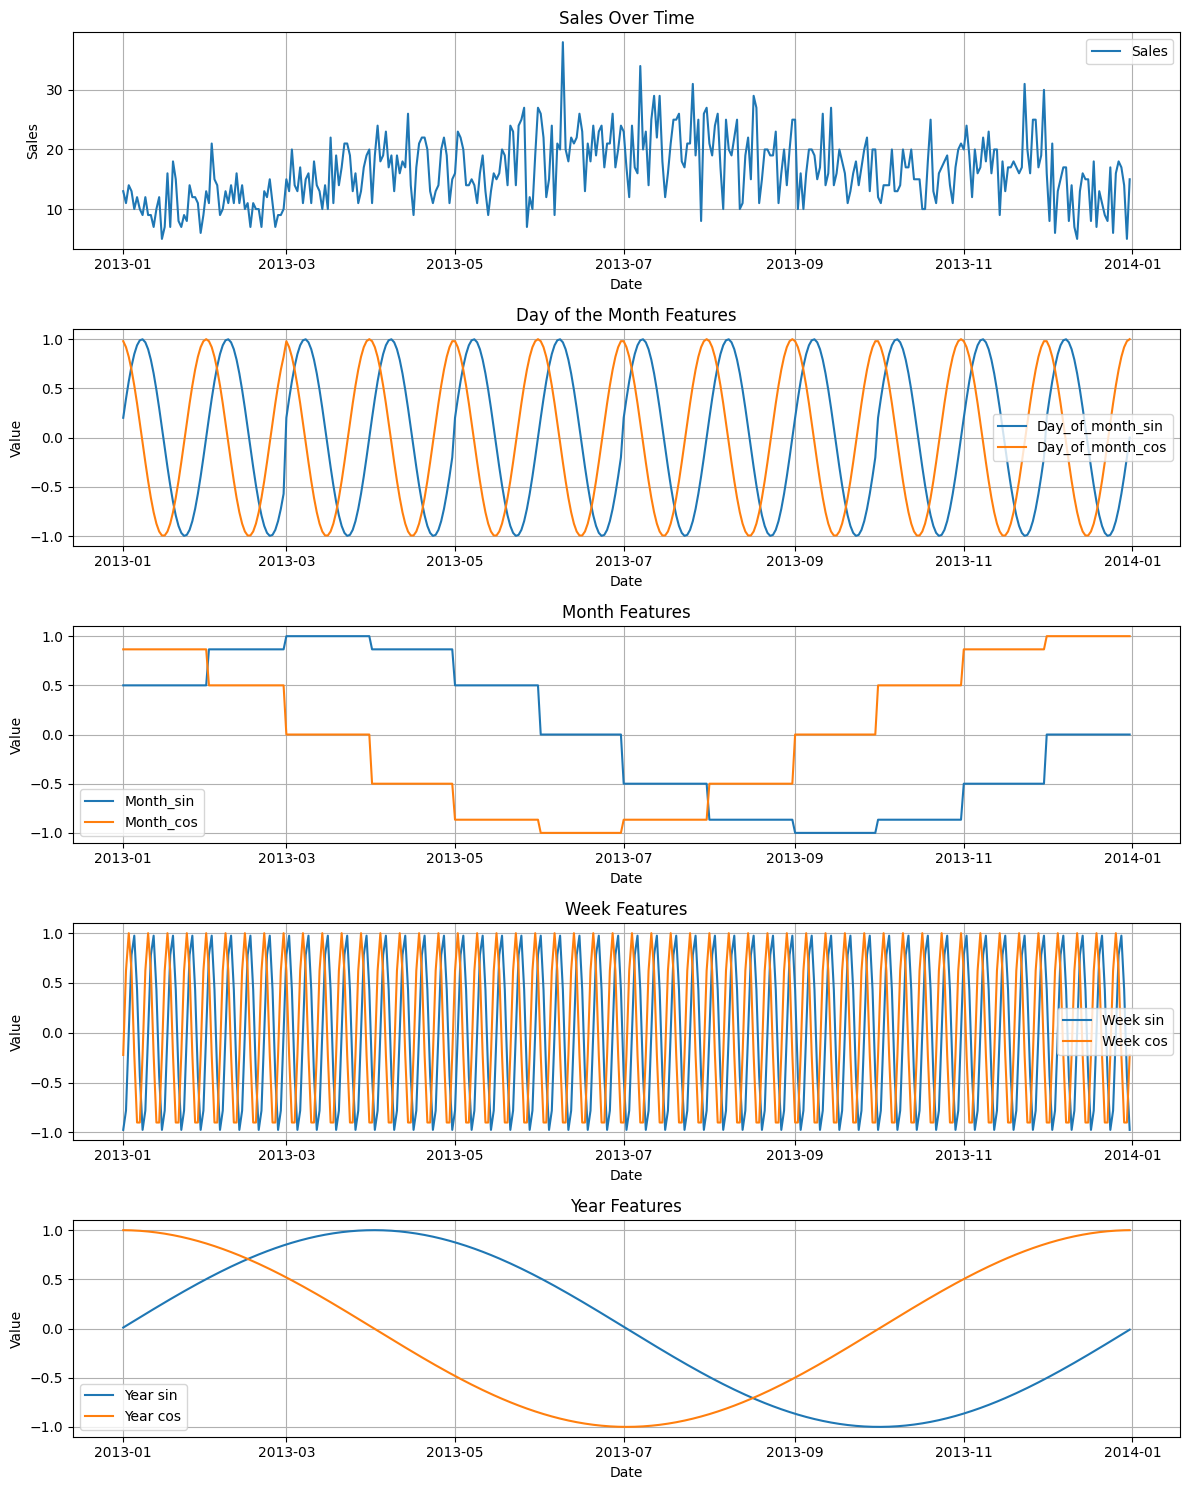

In [13]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Select a subset of the data based on the number of rows to display
subset_df = df.iloc[:365,]

# Plot the sales over time
axes[0].plot(subset_df.index, subset_df['sales'], label='Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title('Sales Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the sine and cosine features for day of the month
axes[1].plot(subset_df.index, subset_df['Day_of_month_sin'], label='Day_of_month_sin')
axes[1].plot(subset_df.index, subset_df['Day_of_month_cos'], label='Day_of_month_cos')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].set_title('Day of the Month Features')
axes[1].legend()
axes[1].grid(True)

# Plot the sine and cosine features for month
axes[2].plot(subset_df.index, subset_df['Month_sin'], label='Month_sin')
axes[2].plot(subset_df.index, subset_df['Month_cos'], label='Month_cos')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].set_title('Month Features')
axes[2].legend()
axes[2].grid(True)

# Plot the sine and cosine features for week
axes[3].plot(subset_df.index, subset_df['Week sin'], label='Week sin')
axes[3].plot(subset_df.index, subset_df['Week cos'], label='Week cos')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].set_title('Week Features')
axes[3].legend()
axes[3].grid(True)

# Plot the sine and cosine features for year
axes[4].plot(subset_df.index, subset_df['Year sin'], label='Year sin')
axes[4].plot(subset_df.index, subset_df['Year cos'], label='Year cos')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Value')
axes[4].set_title('Year Features')
axes[4].legend()
axes[4].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()


In [14]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [15]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_holiday']

date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
             ..
2017-12-27    0
2017-12-28    0
2017-12-29    0
2017-12-30    0
2017-12-31    0
Name: is_holiday, Length: 1826, dtype: int64

Most important frequencies:
Frequency: 0.002738225629791895, Period: 365.2 days
Frequency: 0.1429353778751369, Period: 6.996168582375479 days
Frequency: 0.000547645125958379, Period: 1826.0 days
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days


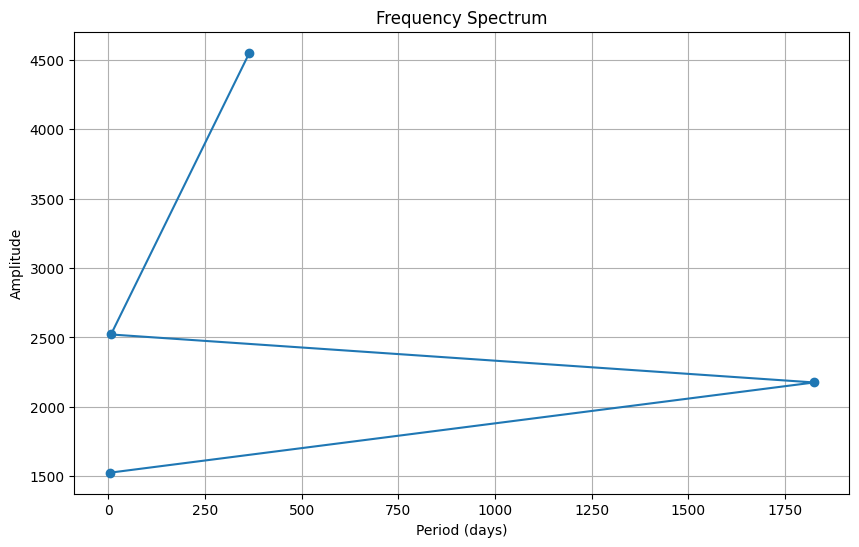

In [16]:
# Compute the FFT
sales_fft = np.fft.fft(df['sales'])

# Get the frequencies
n = len(df)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(sales_fft[:n // 2])

# Find the most important frequencies
top_k = 5  # Number of top frequencies to display
top_indices = np.argsort(amplitudes)[::-1][:top_k]

# Plot the frequency spectrum, skipping the first frequency component
plt.figure(figsize=(10, 6))
plt.title("Frequency Spectrum")
plt.plot(1 / positive_frequencies[top_indices[1:]], amplitudes[top_indices[1:]], 'o-')
plt.xlabel("Period (days)")
plt.ylabel("Amplitude")
plt.grid(True)

# Show the most important frequencies, skipping the first one
print("Most important frequencies:")
for idx in top_indices[1:]:
    period = 1 / positive_frequencies[idx]
    print(f"Frequency: {positive_frequencies[idx]}, Period: {period} days")

# Display the plot
plt.show()

Here's an explanation of the output:

Frequency: 0.002738225629791895, Period: 365.2 days:

This frequency component corresponds to a period of approximately one year (365.2 days). It indicates a yearly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-year cycle, which is common in many businesses due to seasonal variations.
Frequency: 0.1429353778751369, Period: 6.996168582375479 days:

This frequency component corresponds to a period of approximately 7 days (6.996 days). It indicates a weekly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-week cycle. This may be related to weekly trends or behaviors in your data.
Frequency: 0.000547645125958379, Period: 1826.0 days:

This frequency component corresponds to a period of approximately 1826 days (about 5 years). It suggests a longer-term cycle or trend in the sales data that repeats every 5 years. This could be associated with macroeconomic or industry-specific factors.
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days:

This frequency component corresponds to a period of approximately 3.5 days. It indicates a short-term cycle or seasonality in the sales data, possibly related to daily fluctuations or events affecting sales on a daily basis.


In summary, the FFT analysis reveals the underlying periodic components in your sales data, helping you understand the different time scales at which patterns and seasonality occur. These insights can be valuable for forecasting, trend analysis, and understanding the dynamics of your sales data.

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = 1 # number of target feature

In [18]:
FEATURES = ['Month_sin', 'Month_cos', 'Day_of_month_sin','Day_of_month_cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos','is_holiday']

In [19]:
column_indices

{'sales': 0,
 'Month_sin': 1,
 'Month_cos': 2,
 'Day_of_month_sin': 3,
 'Day_of_month_cos': 4,
 'Week sin': 5,
 'Week cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'is_holiday': 9}

In [20]:
train_sales = train_df[['sales']]
test_sales = test_df[['sales']]
val_sales = val_df[['sales']]
val_df = val_df.drop(['sales'], axis=1)
train_df = train_df.drop(['sales'], axis=1)
test_df = test_df.drop(['sales'], axis=1)

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['sales'] = train_sales[['sales']]
val_df['sales'] = val_sales[['sales']]
test_df['sales'] = test_sales[['sales']]

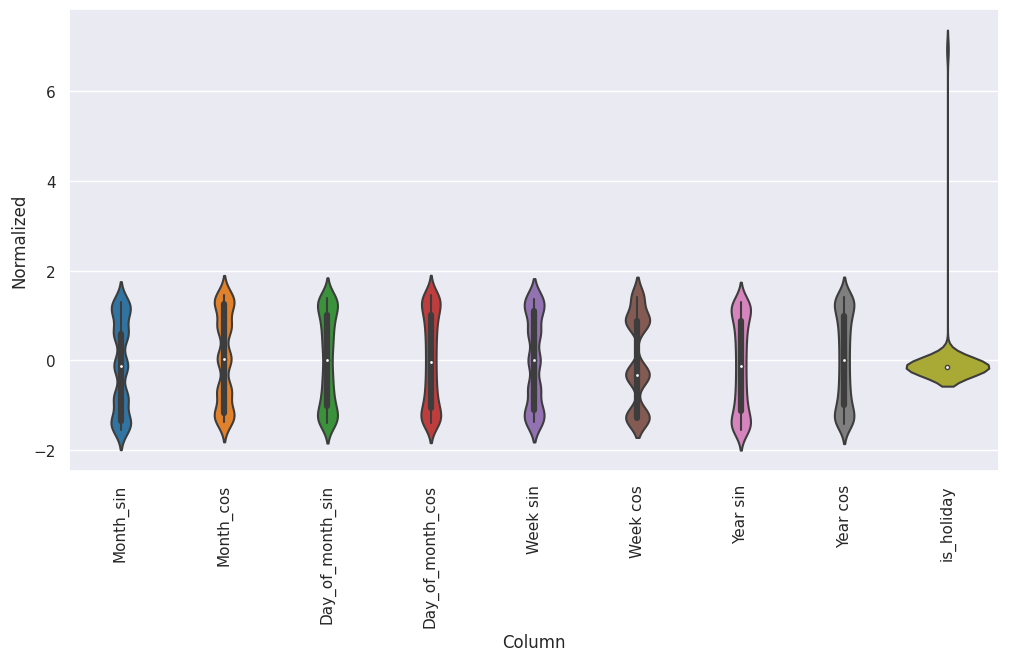

In [22]:
df2 = df.drop(['sales'], axis=1)
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
# Define the color palette
sns.set(style="darkgrid")
palette = sns.color_palette("tab10")
ax = sns.violinplot(x='Column', y='Normalized', data=df_std, palette=palette)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [23]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])
    def get_y_true(self, dataset):
        labels = dataset[:, self.label_indices, :]  # Extract labels using label indices
        return labels

In [24]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Period (day)')

WindowGenerator.plot = plot

In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

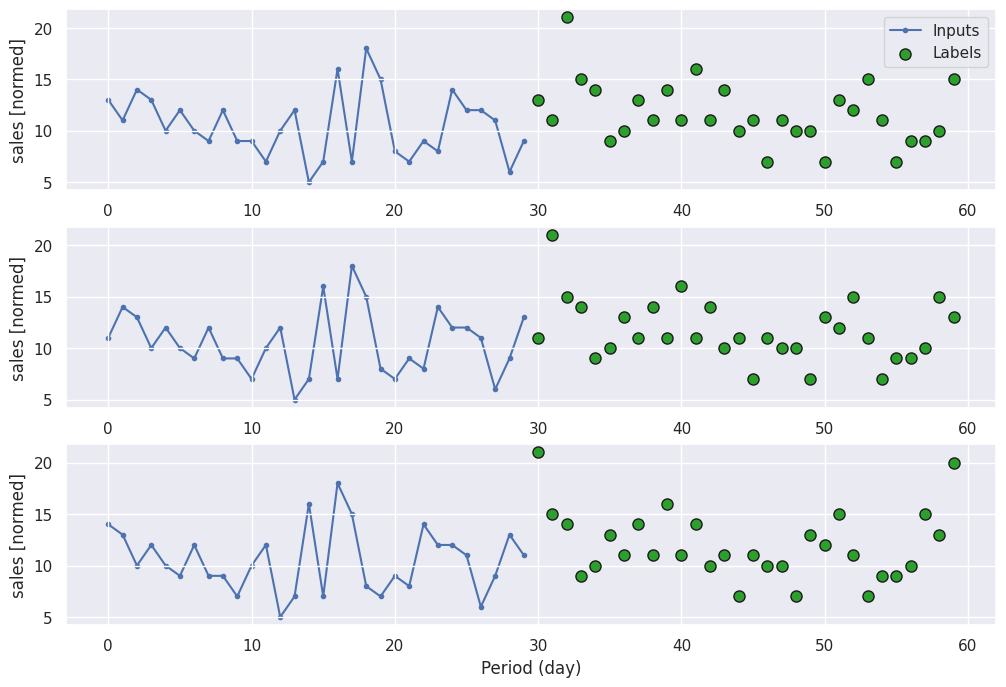

In [28]:
OUT_STEPS = 30
single_step_window = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=OUT_STEPS, #OUT_STEPS,
    label_columns=['sales'])
single_step_window.plot()

In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 10)
Labels shape (batch, time, features): (32, 30, 1)


## BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

def bidirectional_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=512, step=64), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    bidirectional_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='birectional_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 8 Complete [00h 00m 08s]

val_mean_squared_error: 28.553714752197266



Best val_mean_squared_error So Far: 27.687318801879883

Total elapsed time: 00h 01m 18s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 bidirectional (Bidirection  (None, 30, 384)           311808    

 al)                                                             

                                                                 

 dropout (Dropout)           (None, 30, 384)           0         

                                                                 

 flatten (Flatten)           (None, 11520)             0         

                                                                 

 dense (Dense)               (None, 30)                345630    

                                                                 

 reshape (Reshape)           (None, 30, 1)             0         

       

In [ ]:
tuner.results_summary()

Results summary

Results in birectional_lstm_exp/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0001 summary

Hyperparameters:

units: 192

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 27.687318801879883



Trial 0004 summary

Hyperparameters:

units: 256

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 28.08668327331543



Trial 0005 summary

Hyperparameters:

units: 512

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 28.520732879638672



Trial 0007 summary

Hyperparameters:

units: 128

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 28.553714752197266



Trial 0003 summary

Hyperparameters:

units: 384

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 28.55550765991211



Trial 0002 summary

Hyperparameters:

units: 448

tuner/epochs: 2

tuner/initi

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential


model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

#for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
model.add(Bidirectional(LSTM(units=192, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

best_model = model

In [37]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist1 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - 69ms/step - loss: 69.8121 - mean_absolute_error: 6.8130 - mean_absolute_percentage_error: 42.1459 - mean_squared_error: 70.3647 - root_mean_squared_error: 8.3884 - val_loss: 36.3988 - val_mean_absolute_error: 4.6595 - val_mean_absolute_percentage_error: 23.1913 - val_mean_squared_error: 35.0580 - val_root_mean_squared_error: 5.9210
Epoch 2/50
39/39 - 0s - 10ms/step - loss: 29.1234 - mean_absolute_error: 4.2773 - mean_absolute_percentage_error: 26.6033 - mean_squared_error: 29.2554 - root_mean_squared_error: 5.4088 - val_loss: 28.4528 - val_mean_absolute_error: 4.2125 - val_mean_absolute_percentage_error: 23.3461 - val_mean_squared_error: 27.9874 - val_root_mean_squared_error: 5.2903
Epoch 3/50
39/39 - 1s - 15ms/step - loss: 32.5387 - mean_absolute_error: 4.5474 - mean_absolute_percentage_error: 28.1056 - mean_squared_error: 32.7758 - root_mean_squared_error: 5.7250 - val_loss: 28.1128 - val_mean_absolute_error: 4.2243 - val_mean_absolute_percentage_error: 24.160

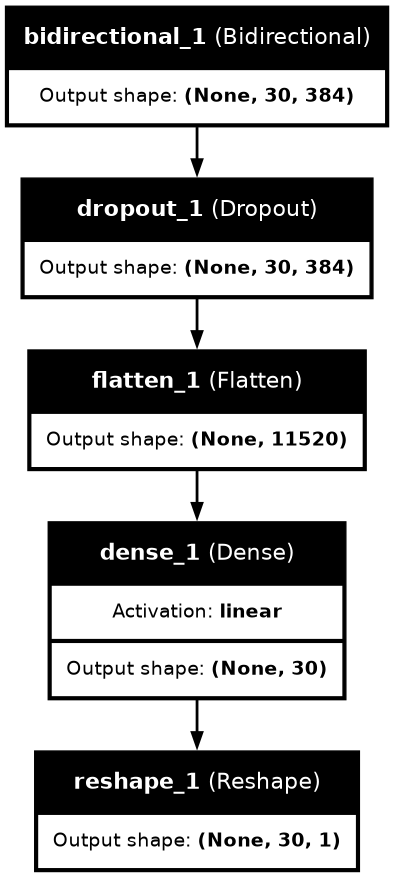

In [38]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [39]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1443 - mean_absolute_error: 3.9476 - mean_absolute_percentage_error: 20.7527 - mean_squared_error: 24.0807 - root_mean_squared_error: 4.9028 


{'loss': 23.4373722076416,
 'mean_absolute_error': 3.912792682647705,
 'mean_absolute_percentage_error': 21.123790740966797,
 'mean_squared_error': 23.08714485168457,
 'root_mean_squared_error': 4.804908275604248}

In [40]:
score

{'loss': 24.554630279541016,
 'mean_absolute_error': 4.061380863189697,
 'mean_absolute_percentage_error': 20.4473876953125,
 'mean_squared_error': 24.407730102539062,
 'root_mean_squared_error': 4.940417766571045}

In [41]:
pd.DataFrame(hist1.history).head()

loss  mean_absolute_error  mean_absolute_percentage_error  \
0  69.812096             6.813002                       42.145947   
1  29.123413             4.277331                       26.603342   
2  32.538685             4.547430                       28.105616   
3  29.598446             4.347520                       26.964914   
4  27.815664             4.208017                       26.041868   

   mean_squared_error  root_mean_squared_error   val_loss  \
0           70.364723                 8.388369  36.398762   
1           29.255444                 5.408830  28.452753   
2           32.775818                 5.725017  28.112753   
3           29.829067                 5.461599  26.276880   
4           28.070162                 5.298128  25.552048   

   val_mean_absolute_error  val_mean_absolute_percentage_error  \
0                 4.659532                           23.191298   
1                 4.212530                           23.346066   
2                 4.224292                           24.160851   
3                 4.070635                           22.737440   
4                 4.036462                           22.356285   

   val_mean_squared_error  val_root_mean_squared_error  
0               35.058041                     5.920983  
1               27.987429                     5.290315  
2               27.698618                     5.262948  
3               25.868696                     5.086128  
4               25.180811                     5.018048

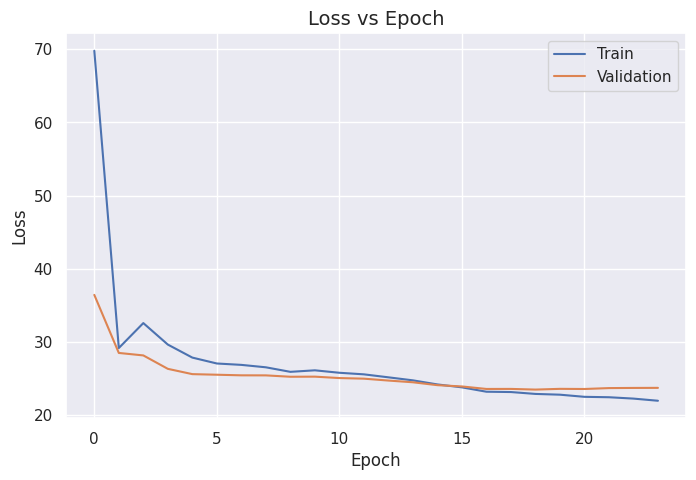

In [42]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("bilstm_loss.png", dpi=300)
plt.show()

In [43]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.4621117
Mean p-value: 0.20666657


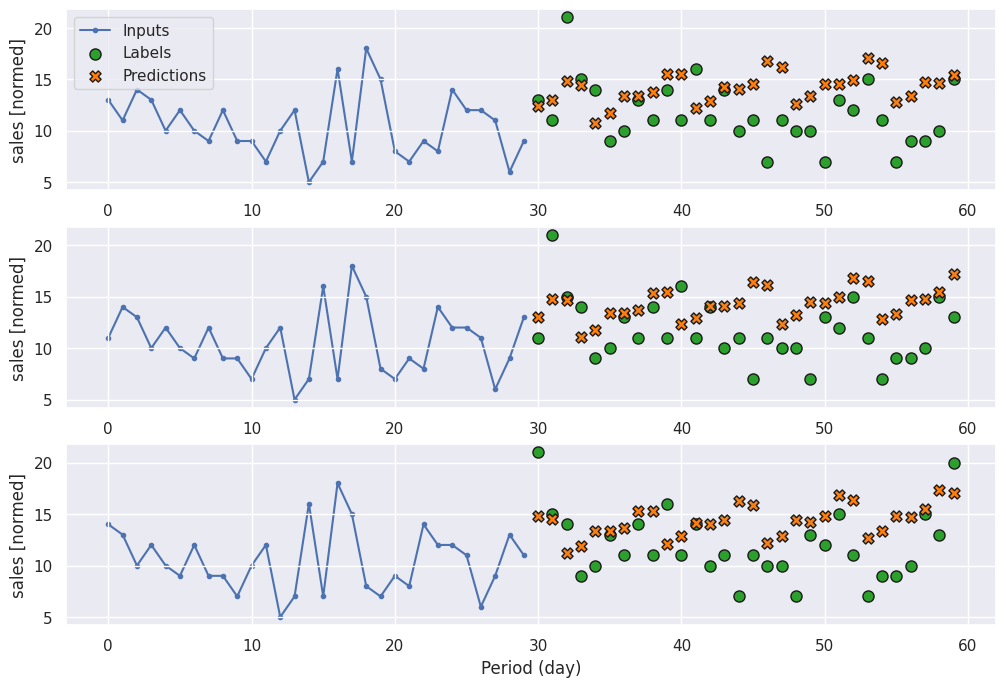

In [44]:
single_step_window.plot(best_model)

## CNN

In [ ]:
def cnn_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
    k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

    model.add(Conv1D(num_filters, k_size, activation='relu'))
    if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    model.add(MaxPooling1D())
    else:
    model.add(AveragePooling1D())

    model.add(Flatten())
    model.add(Dense(hp.Int('units_fully_connected_dense', min_value=16, max_value=512, step=16), activation='relu'))
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear'))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
    model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model

tuner = kt.tuners.Hyperband(
    cnn_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='cnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 150 Complete [00h 00m 09s]

val_mean_squared_error: 26.817073822021484



Best val_mean_squared_error So Far: 26.225170135498047

Total elapsed time: 00h 11m 51s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv1d (Conv1D)             (None, 30, 64)            704       

                                                                 

 average_pooling1d (Average  (None, 15, 64)            0         

 Pooling1D)                                                      

                                                                 

 flatten (Flatten)           (None, 960)               0         

                                                                 

 dense (Dense)               (None, 192)               184512    

                                                                 

 dense_1 (Dense)             (None, 30)                5790      

     

In [ ]:
tuner.results_summary()

Results summary

Results in cnn_exp/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0085 summary

Hyperparameters:

filters_cnn_layer: 64

kernel_size: 1

pooling_: avg

units_fully_connected_dense: 192

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0079

Score: 26.225170135498047



Trial 0144 summary

Hyperparameters:

filters_cnn_layer: 176

kernel_size: 1

pooling_: avg

units_fully_connected_dense: 448

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0141

Score: 26.303508758544922



Trial 0059 summary

Hyperparameters:

filters_cnn_layer: 32

kernel_size: 2

pooling_: avg

units_fully_connected_dense: 160

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 26.349002838134766



Trial 0146 summary

Hyperparameters:

filters_cnn_layer: 16

kernel_size: 1

pooling_: max

units_fully_connected_dense: 

In [84]:
model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

num_filters = 64
k_size = 1

model.add(Conv1D(num_filters, k_size, activation='relu'))

model.add(AveragePooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(192, activation='relu'))
model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear'))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

best_model = model

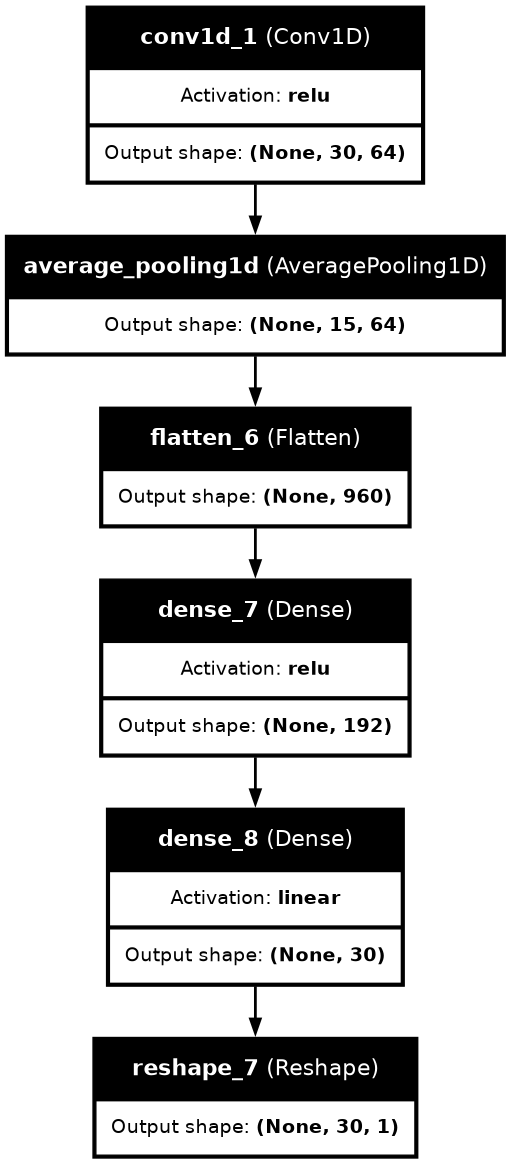

In [85]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [86]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist2 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50


W0000 00:00:1710619488.108395     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710619489.199335     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710619489.818373     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 - 6s - 148ms/step - loss: 105.1591 - mean_absolute_error: 8.2848 - mean_absolute_percentage_error: 46.5604 - mean_squared_error: 106.6431 - root_mean_squared_error: 10.3268 - val_loss: 61.0401 - val_mean_absolute_error: 6.5277 - val_mean_absolute_percentage_error: 40.1096 - val_mean_squared_error: 61.6181 - val_root_mean_squared_error: 7.8497
Epoch 2/50


W0000 00:00:1710619490.271688     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 - 0s - 5ms/step - loss: 38.4670 - mean_absolute_error: 4.9281 - mean_absolute_percentage_error: 30.1814 - mean_squared_error: 38.2816 - root_mean_squared_error: 6.1872 - val_loss: 35.3342 - val_mean_absolute_error: 4.6310 - val_mean_absolute_percentage_error: 24.0471 - val_mean_squared_error: 34.5199 - val_root_mean_squared_error: 5.8754
Epoch 3/50
39/39 - 0s - 6ms/step - loss: 33.6546 - mean_absolute_error: 4.5793 - mean_absolute_percentage_error: 28.8550 - mean_squared_error: 33.7329 - root_mean_squared_error: 5.8080 - val_loss: 31.5252 - val_mean_absolute_error: 4.4283 - val_mean_absolute_percentage_error: 23.9317 - val_mean_squared_error: 31.0270 - val_root_mean_squared_error: 5.5702
Epoch 4/50
39/39 - 0s - 5ms/step - loss: 30.1299 - mean_absolute_error: 4.3226 - mean_absolute_percentage_error: 27.2391 - mean_squared_error: 30.2466 - root_mean_squared_error: 5.4997 - val_loss: 30.3851 - val_mean_absolute_error: 4.3647 - val_mean_absolute_percentage_error: 23.8822 - val_mean_s

W0000 00:00:1710619493.484477     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

W0000 00:00:1710619493.781348     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


W0000 00:00:1710619493.988796     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [87]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.7887 - mean_absolute_error: 4.1342 - mean_absolute_percentage_error: 22.4900 - mean_squared_error: 26.7390 - root_mean_squared_error: 5.1668 


{'loss': 26.340503692626953,
 'mean_absolute_error': 4.113868236541748,
 'mean_absolute_percentage_error': 22.936233520507812,
 'mean_squared_error': 26.06745147705078,
 'root_mean_squared_error': 5.1056294441223145}

In [88]:
score

{'loss': 29.508901596069336,
 'mean_absolute_error': 4.250611305236816,
 'mean_absolute_percentage_error': 23.013065338134766,
 'mean_squared_error': 29.195390701293945,
 'root_mean_squared_error': 5.403275966644287}

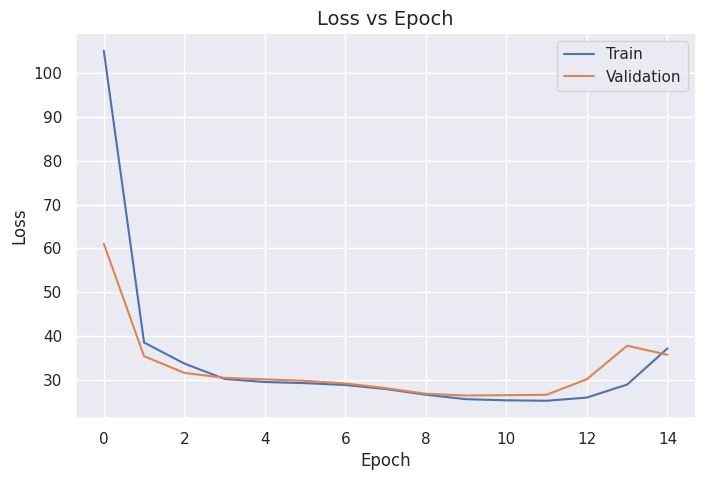

In [89]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_loss.png", dpi=300)
plt.show()

In [90]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -0.17138764
Mean p-value: 0.45867905


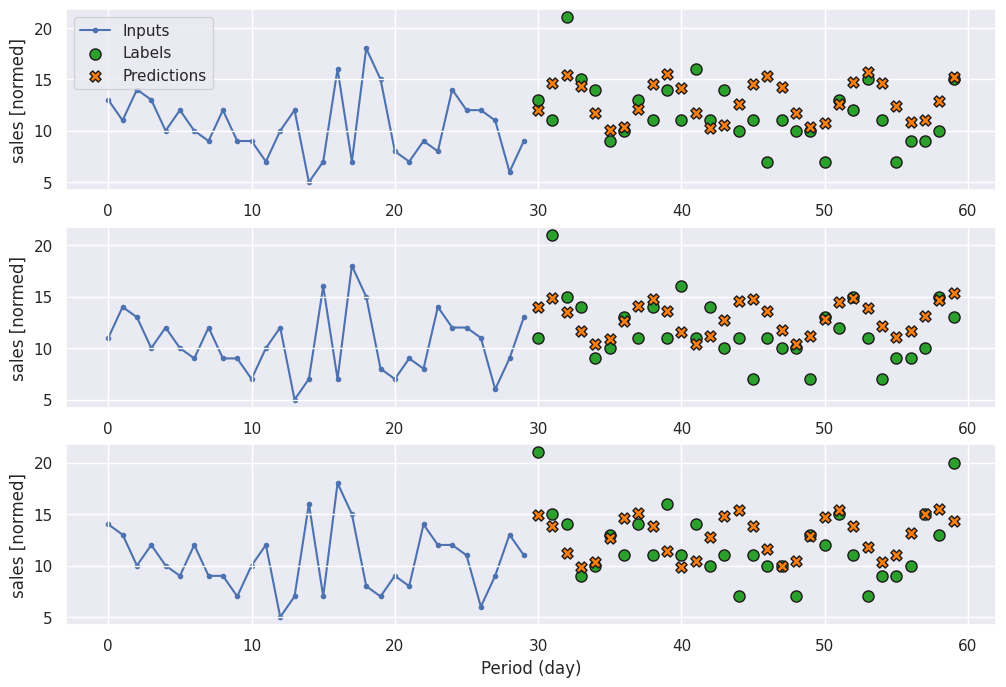

In [91]:
single_step_window.plot(best_model)

## RNN

In [ ]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional, SimpleRNN

def RNN_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))
    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #model.add(SimpleRNN(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    RNN_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='rnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 95 Complete [00h 00m 06s]

val_mean_squared_error: 28.095840454101562



Best val_mean_squared_error So Far: 23.36810874938965

Total elapsed time: 00h 13m 59s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 simple_rnn (SimpleRNN)      (None, 30, 128)           17792     

                                                                 

 dropout (Dropout)           (None, 30, 128)           0         

                                                                 

 flatten (Flatten)           (None, 3840)              0         

                                                                 

 dense (Dense)               (None, 30)                115230    

                                                                 

 reshape (Reshape)           (None, 30, 1)             0         

                                                                 


Total 

In [ ]:
tuner.results_summary()

Results summary

Results in rnn_exp/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0084 summary

Hyperparameters:

units: 128

dropout: 0.1

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0079

Score: 23.36810874938965



Trial 0017 summary

Hyperparameters:

units: 128

dropout: 0.30000000000000004

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0013

Score: 23.39458656311035



Trial 0016 summary

Hyperparameters:

units: 160

dropout: 0.30000000000000004

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0014

Score: 23.420040130615234



Trial 0029 summary

Hyperparameters:

units: 224

dropout: 0.2

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 23.468740463256836



Trial 0085 summary

Hyperparameters:

units: 192

dropout: 0.30000000000000004

tuner/e

In [75]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional, SimpleRNN
model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

model.add(SimpleRNN(units=128, activation="tanh", use_bias=True, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

best_model = model

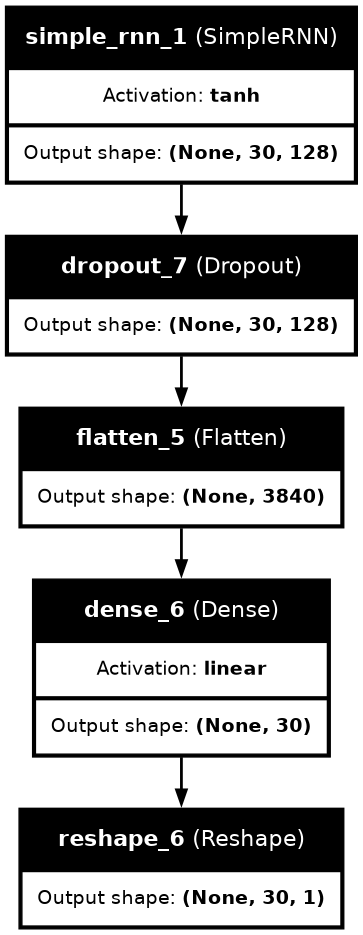

In [76]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [77]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist3 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50


W0000 00:00:1710619219.373867     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710619221.834350     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 - 6s - 147ms/step - loss: 61.1401 - mean_absolute_error: 6.2828 - mean_absolute_percentage_error: 39.8029 - mean_squared_error: 61.9100 - root_mean_squared_error: 7.8683 - val_loss: 30.4818 - val_mean_absolute_error: 4.3823 - val_mean_absolute_percentage_error: 24.4000 - val_mean_squared_error: 29.7346 - val_root_mean_squared_error: 5.4529
Epoch 2/50
39/39 - 0s - 8ms/step - loss: 30.2383 - mean_absolute_error: 4.3763 - mean_absolute_percentage_error: 27.2449 - mean_squared_error: 30.4354 - root_mean_squared_error: 5.5168 - val_loss: 27.3477 - val_mean_absolute_error: 4.1603 - val_mean_absolute_percentage_error: 23.6479 - val_mean_squared_error: 26.8820 - val_root_mean_squared_error: 5.1848
Epoch 3/50
39/39 - 0s - 8ms/step - loss: 28.3727 - mean_absolute_error: 4.2428 - mean_absolute_percentage_error: 26.3468 - mean_squared_error: 28.6178 - root_mean_squared_error: 5.3496 - val_loss: 25.7598 - val_mean_absolute_error: 4.0513 - val_mean_absolute_percentage_error: 22.8705 - val_mean

In [78]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.5134 - mean_absolute_error: 3.9555 - mean_absolute_percentage_error: 21.1606 - mean_squared_error: 24.4435 - root_mean_squared_error: 4.9378 


{'loss': 23.682180404663086,
 'mean_absolute_error': 3.9055216312408447,
 'mean_absolute_percentage_error': 21.425003051757812,
 'mean_squared_error': 23.297300338745117,
 'root_mean_squared_error': 4.826727390289307}

In [79]:
score

{'loss': 23.960289001464844,
 'mean_absolute_error': 4.043116092681885,
 'mean_absolute_percentage_error': 20.878862380981445,
 'mean_squared_error': 23.776538848876953,
 'root_mean_squared_error': 4.876119136810303}

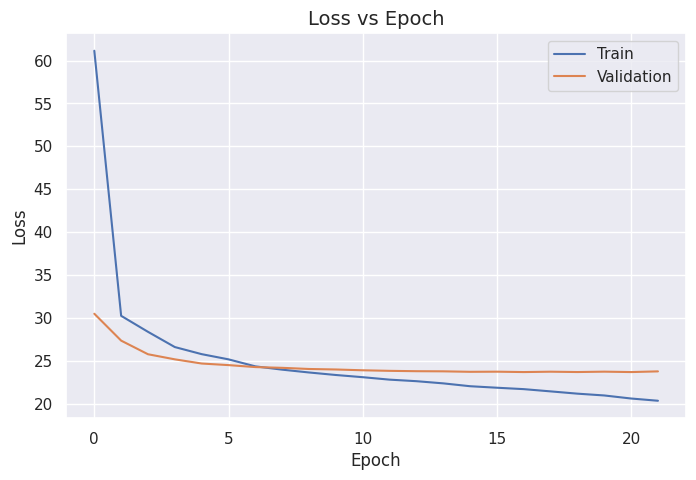

In [80]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("rnn_loss.png", dpi=300)
plt.show()

In [81]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -0.6514868
Mean p-value: 0.52714866


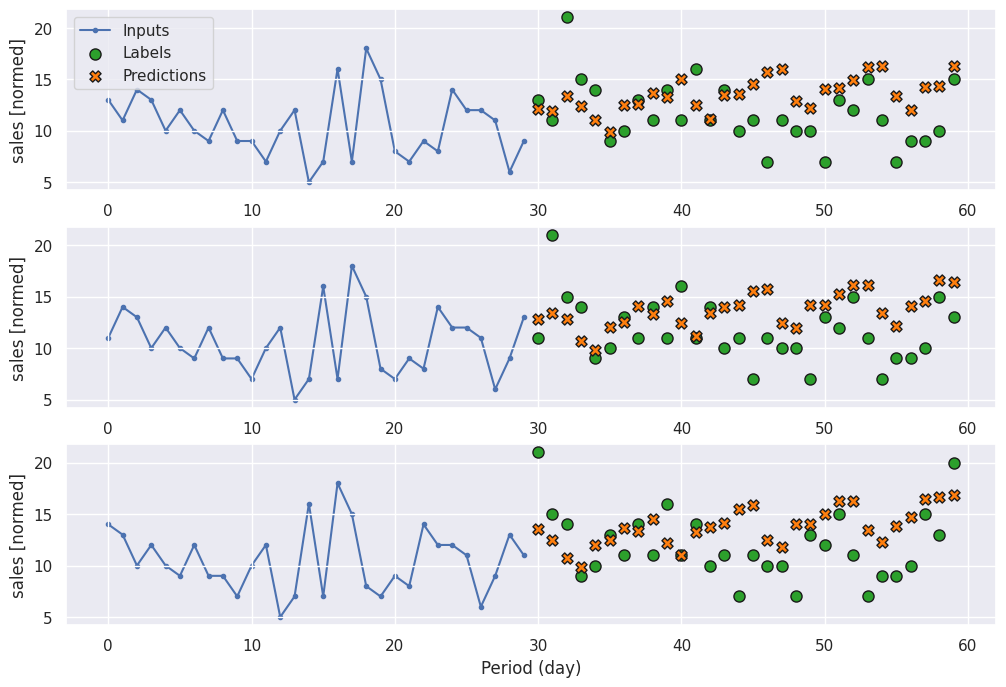

In [82]:
single_step_window.plot(best_model)

## Stacked LSTM

In [ ]:
def stacked_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    stacked_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='stacked_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 96 Complete [00h 00m 09s]

val_mean_squared_error: 38.3703498840332



Best val_mean_squared_error So Far: 28.168014526367188

Total elapsed time: 00h 16m 06s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 30, 512)           1071104   

                                                                 

 dropout (Dropout)           (None, 30, 512)           0         

                                                                 

 lstm_1 (LSTM)               (None, 30, 512)           2099200   

                                                                 

 dropout_1 (Dropout)         (None, 30, 512)           0         

                                                                 

 flatten (Flatten)           (None, 15360)             0         

                                                                 

 dense (

In [ ]:
tuner.results_summary()

Results summary

Results in stacked_lstm_exp/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0058 summary

Hyperparameters:

units: 512

dropout: 0.0

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 28.168014526367188



Trial 0056 summary

Hyperparameters:

units: 480

dropout: 0.0

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 28.25672721862793



Trial 0059 summary

Hyperparameters:

units: 288

dropout: 0.0

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 28.2739315032959



Trial 0076 summary

Hyperparameters:

units: 128

dropout: 0.30000000000000004

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0074

Score: 28.46781349182129



Trial 0057 summary

Hyperparameters:

units: 288

dropout: 0.2

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0



In [50]:
model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

#for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
model.add(LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(Dropout(0.0))
model.add(LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(Dropout(0.0))
model.add(Flatten())
model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

best_model = model

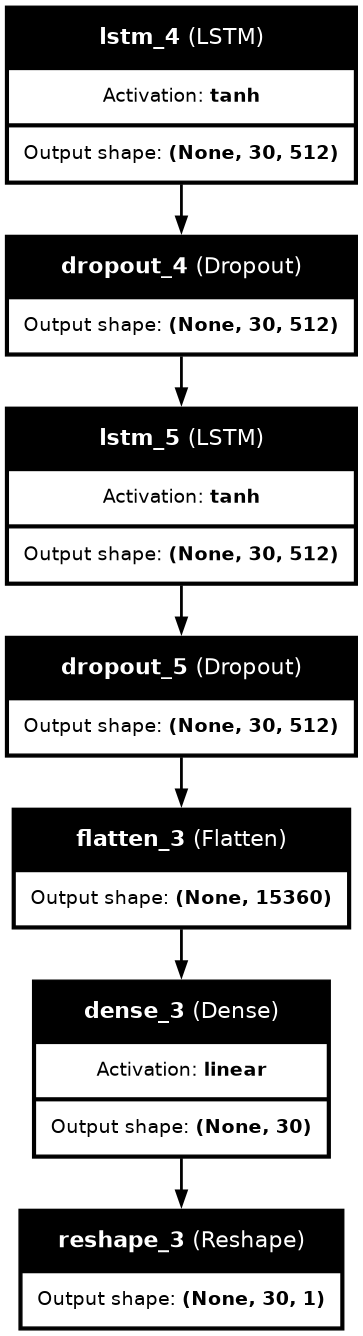

In [51]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [52]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - 69ms/step - loss: 81.9973 - mean_absolute_error: 7.1439 - mean_absolute_percentage_error: 43.0102 - mean_squared_error: 81.9650 - root_mean_squared_error: 9.0535 - val_loss: 48.7205 - val_mean_absolute_error: 5.3232 - val_mean_absolute_percentage_error: 26.4792 - val_mean_squared_error: 45.8239 - val_root_mean_squared_error: 6.7693
Epoch 2/50
39/39 - 1s - 15ms/step - loss: 43.7562 - mean_absolute_error: 5.2778 - mean_absolute_percentage_error: 32.8912 - mean_squared_error: 43.5681 - root_mean_squared_error: 6.6006 - val_loss: 36.2036 - val_mean_absolute_error: 4.7521 - val_mean_absolute_percentage_error: 26.4182 - val_mean_squared_error: 34.8705 - val_root_mean_squared_error: 5.9051
Epoch 3/50
39/39 - 1s - 15ms/step - loss: 38.0461 - mean_absolute_error: 4.9434 - mean_absolute_percentage_error: 31.2535 - mean_squared_error: 38.2942 - root_mean_squared_error: 6.1882 - val_loss: 30.6106 - val_mean_absolute_error: 4.3613 - val_mean_absolute_percentage_error: 23.341

In [53]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.0771 - mean_absolute_error: 3.9429 - mean_absolute_percentage_error: 20.6720 - mean_squared_error: 24.0102 - root_mean_squared_error: 4.8961 


{'loss': 23.5703182220459,
 'mean_absolute_error': 3.902268409729004,
 'mean_absolute_percentage_error': 21.003129959106445,
 'mean_squared_error': 23.202465057373047,
 'root_mean_squared_error': 4.816893577575684}

In [54]:
score

{'loss': 25.6610107421875,
 'mean_absolute_error': 4.114407539367676,
 'mean_absolute_percentage_error': 20.547285079956055,
 'mean_squared_error': 25.436519622802734,
 'root_mean_squared_error': 5.043463230133057}

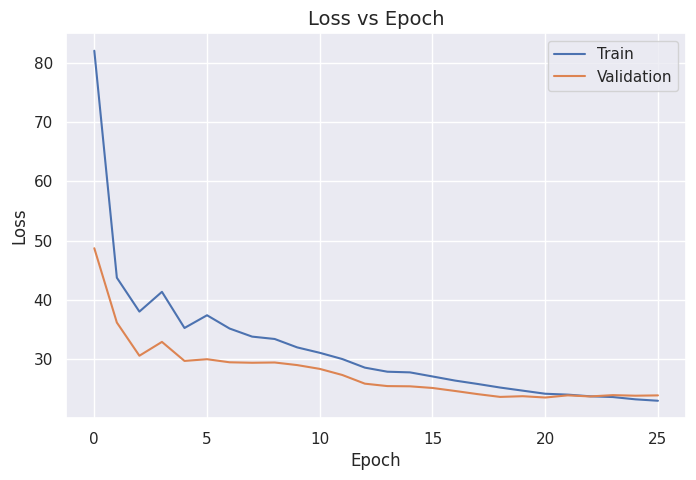

In [55]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("stacked_lstm_loss.png", dpi=300)
plt.show()

In [56]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.6302485
Mean p-value: 0.23526402


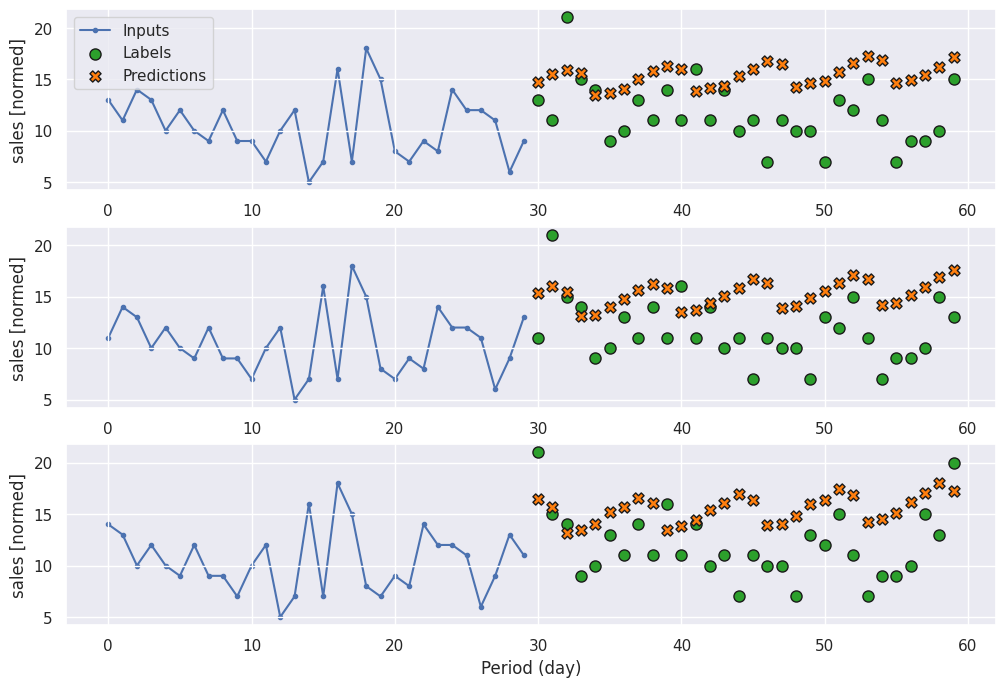

In [57]:
single_step_window.plot(best_model)

## Vanilla LSTM

In [ ]:
def vanila_LSTM(hp):
    inputs = Input(shape=(OUT_STEPS, 10))
    X = LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid')(inputs)
    outputs = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(X)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vanilla_lstm_model")

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    vanila_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='vanilla',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 22 Complete [00h 00m 06s]

val_mean_squared_error: 39.98261642456055



Best val_mean_squared_error So Far: 39.92511749267578

Total elapsed time: 00h 02m 09s

Model: "vanilla_lstm_model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 30, 10)]          0         

                                                                 

 lstm (LSTM)                 (None, 480)               942720    

                                                                 

 dense (Dense)               (None, 30)                14430     

                                                                 

 reshape (Reshape)           (None, 30, 1)             0         

                                                                 


Total params: 957150 (3.65 MB)

Trainable params: 957150 (3.65 MB)

Non-trainable params: 0 (0.00 Byte)

____________________________

In [ ]:
tuner.results_summary()

Results summary

Results in vanilla/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0006 summary

Hyperparameters:

units: 480

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 39.92511749267578



Trial 0000 summary

Hyperparameters:

units: 448

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 39.981056213378906



Trial 0021 summary

Hyperparameters:

units: 512

tuner/epochs: 4

tuner/initial_epoch: 0

tuner/bracket: 1

tuner/round: 0

Score: 39.98261642456055



Trial 0004 summary

Hyperparameters:

units: 416

tuner/epochs: 2

tuner/initial_epoch: 0

tuner/bracket: 2

tuner/round: 0

Score: 40.23431396484375



Trial 0016 summary

Hyperparameters:

units: 480

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0012

Score: 40.30371856689453



Trial 0017 summary

Hyperparameters:

units: 448

tuner/epochs: 10

tu

In [58]:
inputs = Input(shape=(OUT_STEPS, 10))
X = LSTM(units=448, activation='tanh', recurrent_activation='sigmoid')(inputs)
outputs = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(X)
outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vanilla_lstm_model")

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])
best_model = model

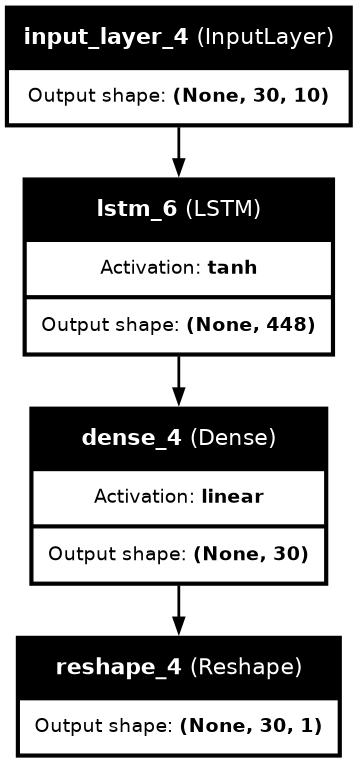

In [59]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [60]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist5 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 2s - 47ms/step - loss: 173.9315 - mean_absolute_error: 11.4469 - mean_absolute_percentage_error: 58.2164 - mean_squared_error: 174.8671 - root_mean_squared_error: 13.2237 - val_loss: 63.5662 - val_mean_absolute_error: 6.0459 - val_mean_absolute_percentage_error: 27.6458 - val_mean_squared_error: 59.4539 - val_root_mean_squared_error: 7.7106
Epoch 2/50
39/39 - 0s - 8ms/step - loss: 39.4509 - mean_absolute_error: 4.9477 - mean_absolute_percentage_error: 30.9776 - mean_squared_error: 38.7675 - root_mean_squared_error: 6.2264 - val_loss: 42.0955 - val_mean_absolute_error: 5.0423 - val_mean_absolute_percentage_error: 27.3639 - val_mean_squared_error: 39.9834 - val_root_mean_squared_error: 6.3232
Epoch 3/50
39/39 - 0s - 8ms/step - loss: 42.4789 - mean_absolute_error: 5.1430 - mean_absolute_percentage_error: 33.2075 - mean_squared_error: 41.7149 - root_mean_squared_error: 6.4587 - val_loss: 43.2854 - val_mean_absolute_error: 5.0898 - val_mean_absolute_percentage_error: 26.9

In [61]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.2701 - mean_absolute_error: 4.8909 - mean_absolute_percentage_error: 25.5216 - mean_squared_error: 36.8861 - root_mean_squared_error: 6.0689 


{'loss': 42.09553146362305,
 'mean_absolute_error': 5.0423264503479,
 'mean_absolute_percentage_error': 27.36394500732422,
 'mean_squared_error': 39.983360290527344,
 'root_mean_squared_error': 6.323239803314209}

In [62]:
score

{'loss': 43.53019332885742,
 'mean_absolute_error': 5.278786659240723,
 'mean_absolute_percentage_error': 25.591039657592773,
 'mean_squared_error': 43.612274169921875,
 'root_mean_squared_error': 6.603959083557129}

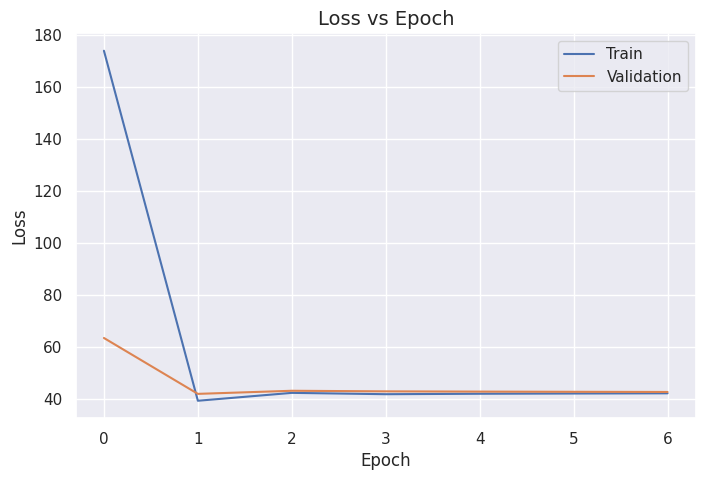

In [63]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("vanilla_lstm_loss.png", dpi=300)
plt.show()

In [64]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -4.2031035
Mean p-value: 0.0075615253


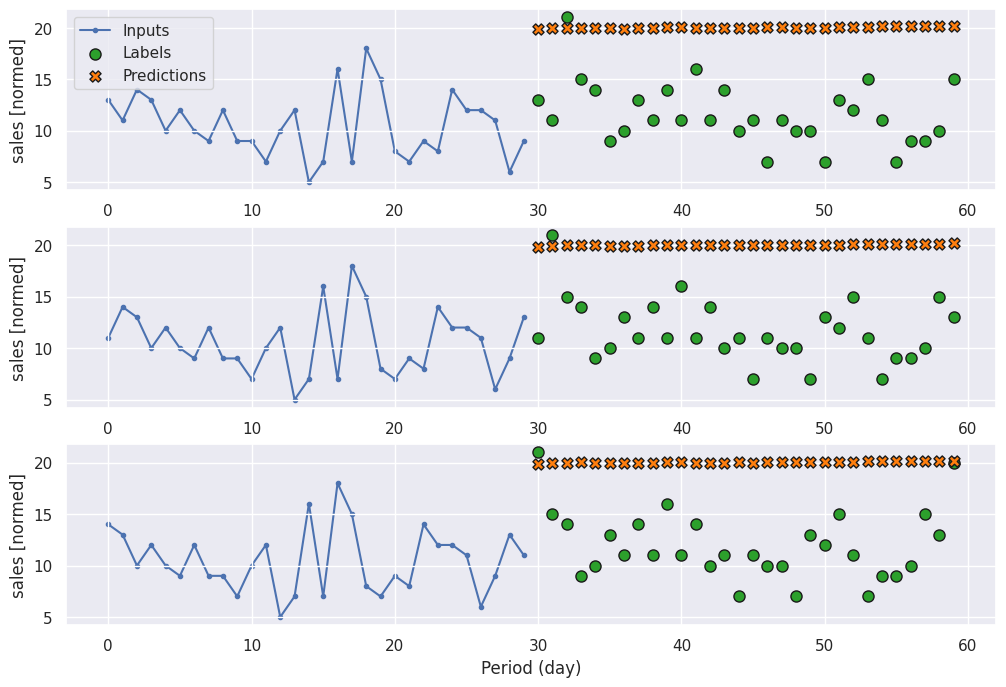

In [65]:
single_step_window.plot(best_model)

## MLP

In [ ]:
def mlp_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #  hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh', 'relu'])
    hp_activation=hp.Choice('activation', ['relu', 'tanh', 'relu'])
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation=hp_activation))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.0)))

    model.add(Dense(num_features, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model


tuner = kt.tuners.Hyperband(
    mlp_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='mlp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 150 Complete [00h 00m 07s]

val_mean_squared_error: 39.10385513305664



Best val_mean_squared_error So Far: 27.790449142456055

Total elapsed time: 00h 10m 20s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 30, 512)           5632      

                                                                 

 dropout (Dropout)           (None, 30, 512)           0         

                                                                 

 dense_1 (Dense)             (None, 30, 1)             513       

                                                                 


Total params: 6145 (24.00 KB)

Trainable params: 6145 (24.00 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary

Results in mlp/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0054 summary

Hyperparameters:

activation: tanh

units: 512

dropout: 0.0

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0049

Score: 27.790449142456055



Trial 0136 summary

Hyperparameters:

activation: tanh

units: 512

dropout: 0.1

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0132

Score: 27.80330467224121



Trial 0016 summary

Hyperparameters:

activation: tanh

units: 480

dropout: 0.30000000000000004

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0012

Score: 27.84955406188965



Trial 0084 summary

Hyperparameters:

activation: tanh

units: 448

dropout: 0.1

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0080

Score: 27.90016746520996



Trial 0024 sum

In [92]:
model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

#for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
#  hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh', 'relu'])
hp_activation='tanh'
model.add(Dense(units=512, activation=hp_activation))
model.add(Dropout(0.0))

model.add(Dense(num_features, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

best_model = model

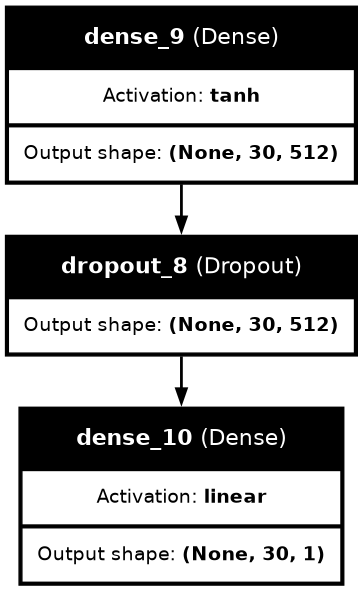

In [93]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [94]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist6 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - 83ms/step - loss: 158.1421 - mean_absolute_error: 10.8140 - mean_absolute_percentage_error: 55.9293 - mean_squared_error: 160.0571 - root_mean_squared_error: 12.6514 - val_loss: 44.3381 - val_mean_absolute_error: 5.0906 - val_mean_absolute_percentage_error: 25.1269 - val_mean_squared_error: 42.0468 - val_root_mean_squared_error: 6.4844
Epoch 2/50
39/39 - 0s - 5ms/step - loss: 34.9469 - mean_absolute_error: 4.6618 - mean_absolute_percentage_error: 30.1340 - mean_squared_error: 34.7324 - root_mean_squared_error: 5.8934 - val_loss: 35.5437 - val_mean_absolute_error: 4.6471 - val_mean_absolute_percentage_error: 25.4436 - val_mean_squared_error: 34.3241 - val_root_mean_squared_error: 5.8587
Epoch 3/50
39/39 - 0s - 4ms/step - loss: 34.0433 - mean_absolute_error: 4.5698 - mean_absolute_percentage_error: 28.8968 - mean_squared_error: 33.8231 - root_mean_squared_error: 5.8158 - val_loss: 34.4826 - val_mean_absolute_error: 4.5611 - val_mean_absolute_percentage_error: 24.3

In [95]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.1844 - mean_absolute_error: 4.0043 - mean_absolute_percentage_error: 20.9931 - mean_squared_error: 25.1034 - root_mean_squared_error: 5.0083 


{'loss': 25.677410125732422,
 'mean_absolute_error': 4.022544860839844,
 'mean_absolute_percentage_error': 21.58186149597168,
 'mean_squared_error': 25.231733322143555,
 'root_mean_squared_error': 5.023119926452637}

In [96]:
score

{'loss': 28.141143798828125,
 'mean_absolute_error': 4.152456760406494,
 'mean_absolute_percentage_error': 20.824472427368164,
 'mean_squared_error': 27.893354415893555,
 'root_mean_squared_error': 5.281415939331055}

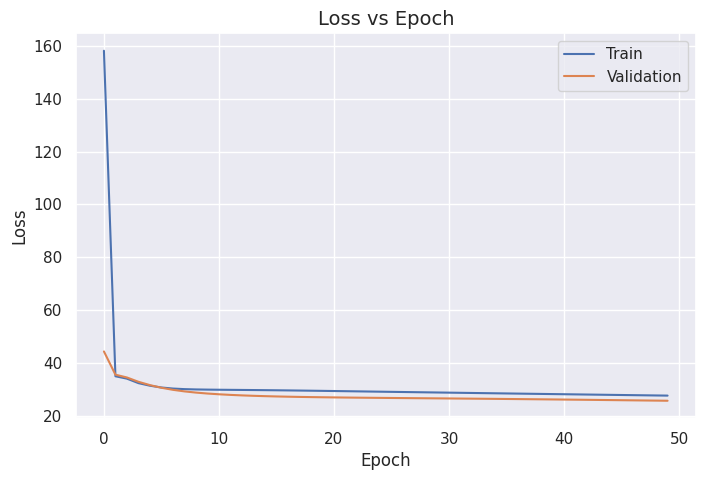

In [97]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("mlp_loss.png", dpi=300)
plt.show()

In [98]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -2.1991768
Mean p-value: 0.044341218


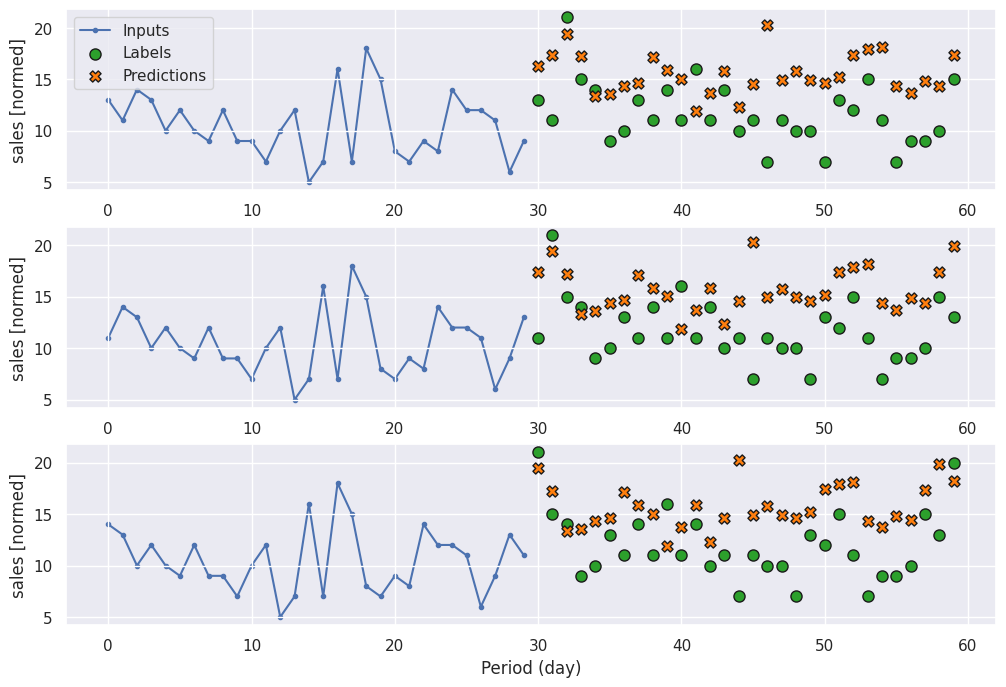

In [99]:
single_step_window.plot(best_model)

## GRU

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

def gru(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    gru,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='gru',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 96 Complete [00h 00m 09s]

val_mean_squared_error: 26.759309768676758



Best val_mean_squared_error So Far: 23.837831497192383

Total elapsed time: 00h 13m 32s

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 gru (GRU)                   (None, 30, 192)           117504    

                                                                 

 dropout (Dropout)           (None, 30, 192)           0         

                                                                 

 flatten (Flatten)           (None, 5760)              0         

                                                                 

 dense (Dense)               (None, 30)                172830    

                                                                 

 reshape (Reshape)           (None, 30, 1)             0         

                                                                 


Total

In [ ]:
tuner.results_summary()

Results summary

Results in gru/demand forecasting

Showing 10 best trials

Objective(name="val_mean_squared_error", direction="min")



Trial 0016 summary

Hyperparameters:

units: 192

dropout: 0.4

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 2

tuner/round: 2

tuner/trial_id: 0015

Score: 23.837831497192383



Trial 0054 summary

Hyperparameters:

units: 160

dropout: 0.0

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tuner/round: 1

tuner/trial_id: 0051

Score: 23.861469268798828



Trial 0089 summary

Hyperparameters:

units: 224

dropout: 0.30000000000000004

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 23.964889526367188



Trial 0059 summary

Hyperparameters:

units: 224

dropout: 0.2

tuner/epochs: 10

tuner/initial_epoch: 0

tuner/bracket: 0

tuner/round: 0

Score: 23.995479583740234



Trial 0024 summary

Hyperparameters:

units: 160

dropout: 0.2

tuner/epochs: 10

tuner/initial_epoch: 4

tuner/bracket: 1

tun

In [112]:
model = tf.keras.Sequential()
model.add(Input(shape=(OUT_STEPS, 10)))

#for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
model.add(GRU(units=192, return_sequences=True))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])
best_model = model

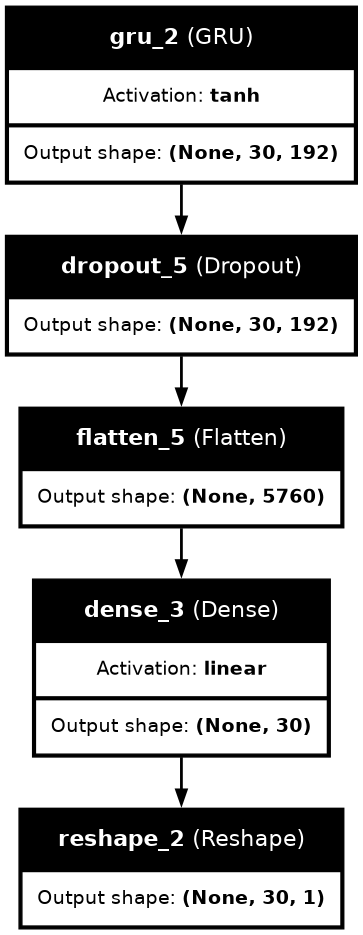

In [113]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [114]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 2s - 44ms/step - loss: 61.0512 - mean_absolute_error: 6.2842 - mean_absolute_percentage_error: 39.8268 - mean_squared_error: 61.5078 - root_mean_squared_error: 7.8427 - val_loss: 33.3237 - val_mean_absolute_error: 4.5074 - val_mean_absolute_percentage_error: 23.7430 - val_mean_squared_error: 32.1823 - val_root_mean_squared_error: 5.6729
Epoch 2/50
39/39 - 0s - 7ms/step - loss: 28.5680 - mean_absolute_error: 4.2217 - mean_absolute_percentage_error: 26.5184 - mean_squared_error: 28.6732 - root_mean_squared_error: 5.3547 - val_loss: 28.0071 - val_mean_absolute_error: 4.1845 - val_mean_absolute_percentage_error: 23.0801 - val_mean_squared_error: 27.5037 - val_root_mean_squared_error: 5.2444
Epoch 3/50
39/39 - 0s - 7ms/step - loss: 28.4351 - mean_absolute_error: 4.2169 - mean_absolute_percentage_error: 26.2077 - mean_squared_error: 28.6322 - root_mean_squared_error: 5.3509 - val_loss: 26.5713 - val_mean_absolute_error: 4.0809 - val_mean_absolute_percentage_error: 22.3226 

In [115]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0770 - mean_absolute_error: 3.9596 - mean_absolute_percentage_error: 21.3455 - mean_squared_error: 23.9942 - root_mean_squared_error: 4.8933 


{'loss': 23.69317054748535,
 'mean_absolute_error': 3.924405813217163,
 'mean_absolute_percentage_error': 21.751319885253906,
 'mean_squared_error': 23.237712860107422,
 'root_mean_squared_error': 4.820550918579102}

In [116]:
score

{'loss': 23.982484817504883,
 'mean_absolute_error': 4.0188889503479,
 'mean_absolute_percentage_error': 20.776975631713867,
 'mean_squared_error': 23.784841537475586,
 'root_mean_squared_error': 4.876970291137695}

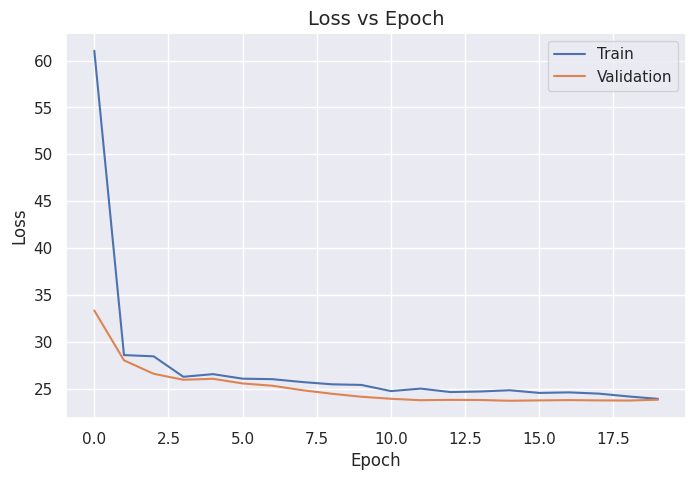

In [117]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("stacked_lstm_loss.png", dpi=300)
plt.show()

In [118]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -0.6693428
Mean p-value: 0.524219


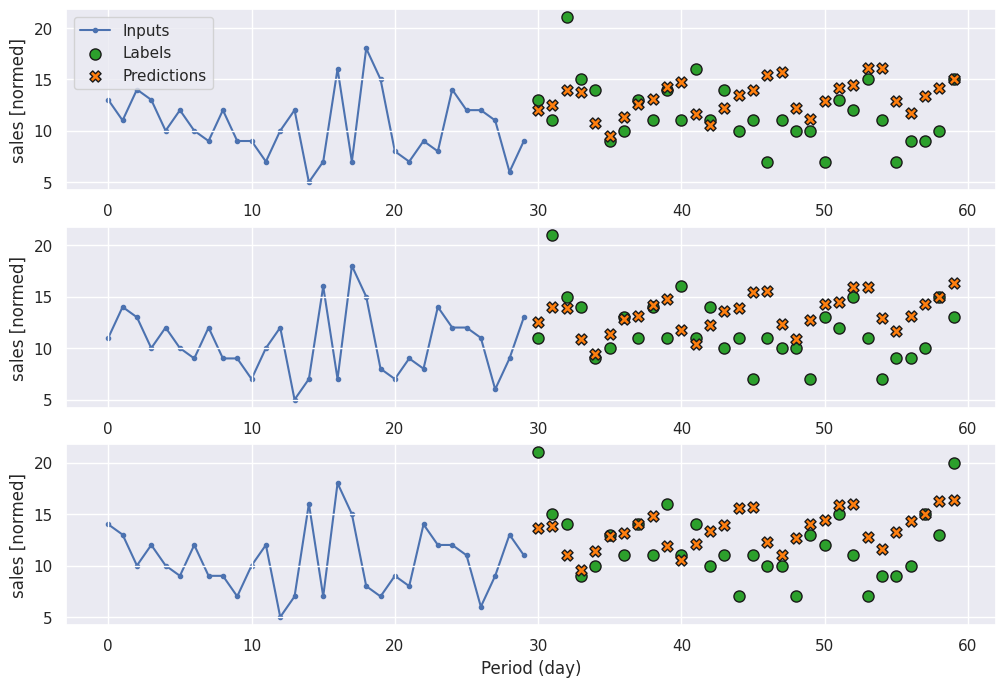

In [119]:
single_step_window.plot(best_model)

## CNN-LSTM-GRU (Proposed)

In [ ]:
!pip install keras-multi-head

In [96]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate, GRU, MultiHeadAttention
import keras

def hybrid_model(hp):
    inputs = Input(shape=(OUT_STEPS, 10))

    num_filters = hp.Int('filters_cnn_layer', min_value=32, max_value=512, step=32)
    k_size = hp.Int('kernel_size', min_value=1, max_value=5, step=1)

    model1=Conv1D(num_filters, k_size, activation='relu')(inputs)
    model1=Conv1D(num_filters, k_size, activation='relu')(model1)
    #model1=tf.keras.layers.BatchNormalization()(model1)
    #if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    #    model1=MaxPooling1D(pool_size=3)(model1)
    #else:
    #    model1=AveragePooling1D(pool_size=3)(model1)
    model1=MaxPooling1D(pool_size=3)(model1)
    model1=Dense(128, activation='relu')(model1)
    model1=Flatten()(model1)

    model2=Bidirectional(LSTM(units=192, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))(inputs)
    model4 = Dropout(0.2)(model2)
    model2=Flatten()(model2)

    model3=Bidirectional(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))(inputs)
    model4 = Dropout(0.4)(model4)
    model3=Flatten()(model3)

    model4=LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(inputs)
    model4 = Dropout(0.2)(model4)
    model4=LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(model4)
    model4 = Dropout(0.2)(model4)
    model4=Flatten()(model4)

    # Concatenate outputs of all models
    concatenated = Concatenate()([model1, model2, model3, model4])

    # Attention Mix
    #CrossAT1 = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=1)(model1,model2,model3,model4)

    model = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear')(concatenated)
    out = tf.keras.layers.Reshape([OUT_STEPS, num_features])(model)

    model = tf.keras.models.Model(inputs=[inputs], outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model

tuner = kt.tuners.Hyperband(
    hybrid_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=3, #5
    directory='hybrid_model_',
    project_name='demand forecasting')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 10))
best_model.summary()

Trial 90 Complete [00h 00m 16s]
val_mean_squared_error: 23.64952278137207

Best val_mean_squared_error So Far: 23.292865753173828
Total elapsed time: 00h 16m 58s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 352)   │      3,872 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 30, 64)    │     19,200 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 352)   │    124,256 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 64)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 10, 352)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 30, 64)    │     33,024 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 128)   │     45,184 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 384)   │    311,808 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 128)   │     29,184 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 11520)     │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3840)      │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1920)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18560)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │    556,830 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 30, 1)     │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,123,358 (4.29 MB)

 Trainable params: 1,123,358 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
tuner.results_summary()

Results summary
Results in hybrid_model_/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0016 summary
Hyperparameters:
filters_cnn_layer: 352
kernel_size: 1
units: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 23.292865753173828

Trial 0046 summary
Hyperparameters:
filters_cnn_layer: 384
kernel_size: 3
units: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0043
Score: 23.35036849975586

Trial 0017 summary
Hyperparameters:
filters_cnn_layer: 288
kernel_size: 4
units: 96
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 23.375553131103516

Trial 0088 summary
Hyperparameters:
filters_cnn_layer: 96
kernel_size: 3
units: 128
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 23.443603515625

Trial 0076 summary
Hyperparameters:
filters_cnn_layer: 256
kernel_s

In [131]:
inputs = Input(shape=(OUT_STEPS, 10))

#num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
#k_size = hp.Int('kernel_size', min_value=1, max_value=5, step=1)

model1=Conv1D(352, 1, activation='relu')(inputs)
model1=Conv1D(352, 1, activation='relu')(model1)

model1=MaxPooling1D(pool_size=3)(model1)
model1=Dense(128, activation='relu')(model1)
model1=Flatten()(model1)

model2=Bidirectional(LSTM(units=192, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))(inputs)
model4 = Dropout(0.2)(model2)
model2=Flatten()(model2)

model3=Bidirectional(GRU(units=64, return_sequences=True))(inputs)
model4 = Dropout(0.4)(model4)
model3=Flatten()(model3)

model4=LSTM(units=64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(inputs)
model4 = Dropout(0.2)(model4)
model4=LSTM(units=64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(model4)
model4 = Dropout(0.2)(model4)
model4=Flatten()(model4)

# Concatenate outputs of all models
concatenated = Concatenate()([model1, model2, model3, model4])

# Attention Mix
#CrossAT1 = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=1)(model1,model2,model3,model4)

model = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear')(concatenated)
out = tf.keras.layers.Reshape([OUT_STEPS, num_features])(model)

model = tf.keras.models.Model(inputs=[inputs], outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])
best_model = model

In [132]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.keras'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')
hist4 =  best_model.fit(single_step_window.train,
                        batch_size=32,
                        epochs=50,
                        verbose=2,
                        validation_data=single_step_window.val,
                        callbacks=[lr_reducer,checkpoint])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 8s - 196ms/step - loss: 75.4521 - mean_absolute_error: 7.0944 - mean_absolute_percentage_error: 43.1008 - mean_squared_error: 76.6564 - root_mean_squared_error: 8.7554 - val_loss: 36.8345 - val_mean_absolute_error: 4.9598 - val_mean_absolute_percentage_error: 30.7646 - val_mean_squared_error: 36.7932 - val_root_mean_squared_error: 6.0657 - learning_rate: 0.0010
Epoch 2/50
39/39 - 1s - 21ms/step - loss: 37.1944 - mean_absolute_error: 4.9250 - mean_absolute_percentage_error: 30.8790 - mean_squared_error: 37.5244 - root_mean_squared_error: 6.1257 - val_loss: 27.6308 - val_mean_absolute_error: 4.1965 - val_mean_absolute_percentage_error: 23.9243 - val_mean_squared_error: 27.1822 - val_root_mean_squared_error: 5.2137 - learning_rate: 0.0010
Epoch 3/50
39/39 - 1s - 20ms/step - loss: 27.9032 - mean_absolute_error: 4.1982 - mean_absolute_percentage_error: 26.1664 - mean_squared_error: 28.1154 - root_mean_squared_error: 5.3024 - val_loss: 25.8179 - val_mean_absolute_error: 4.

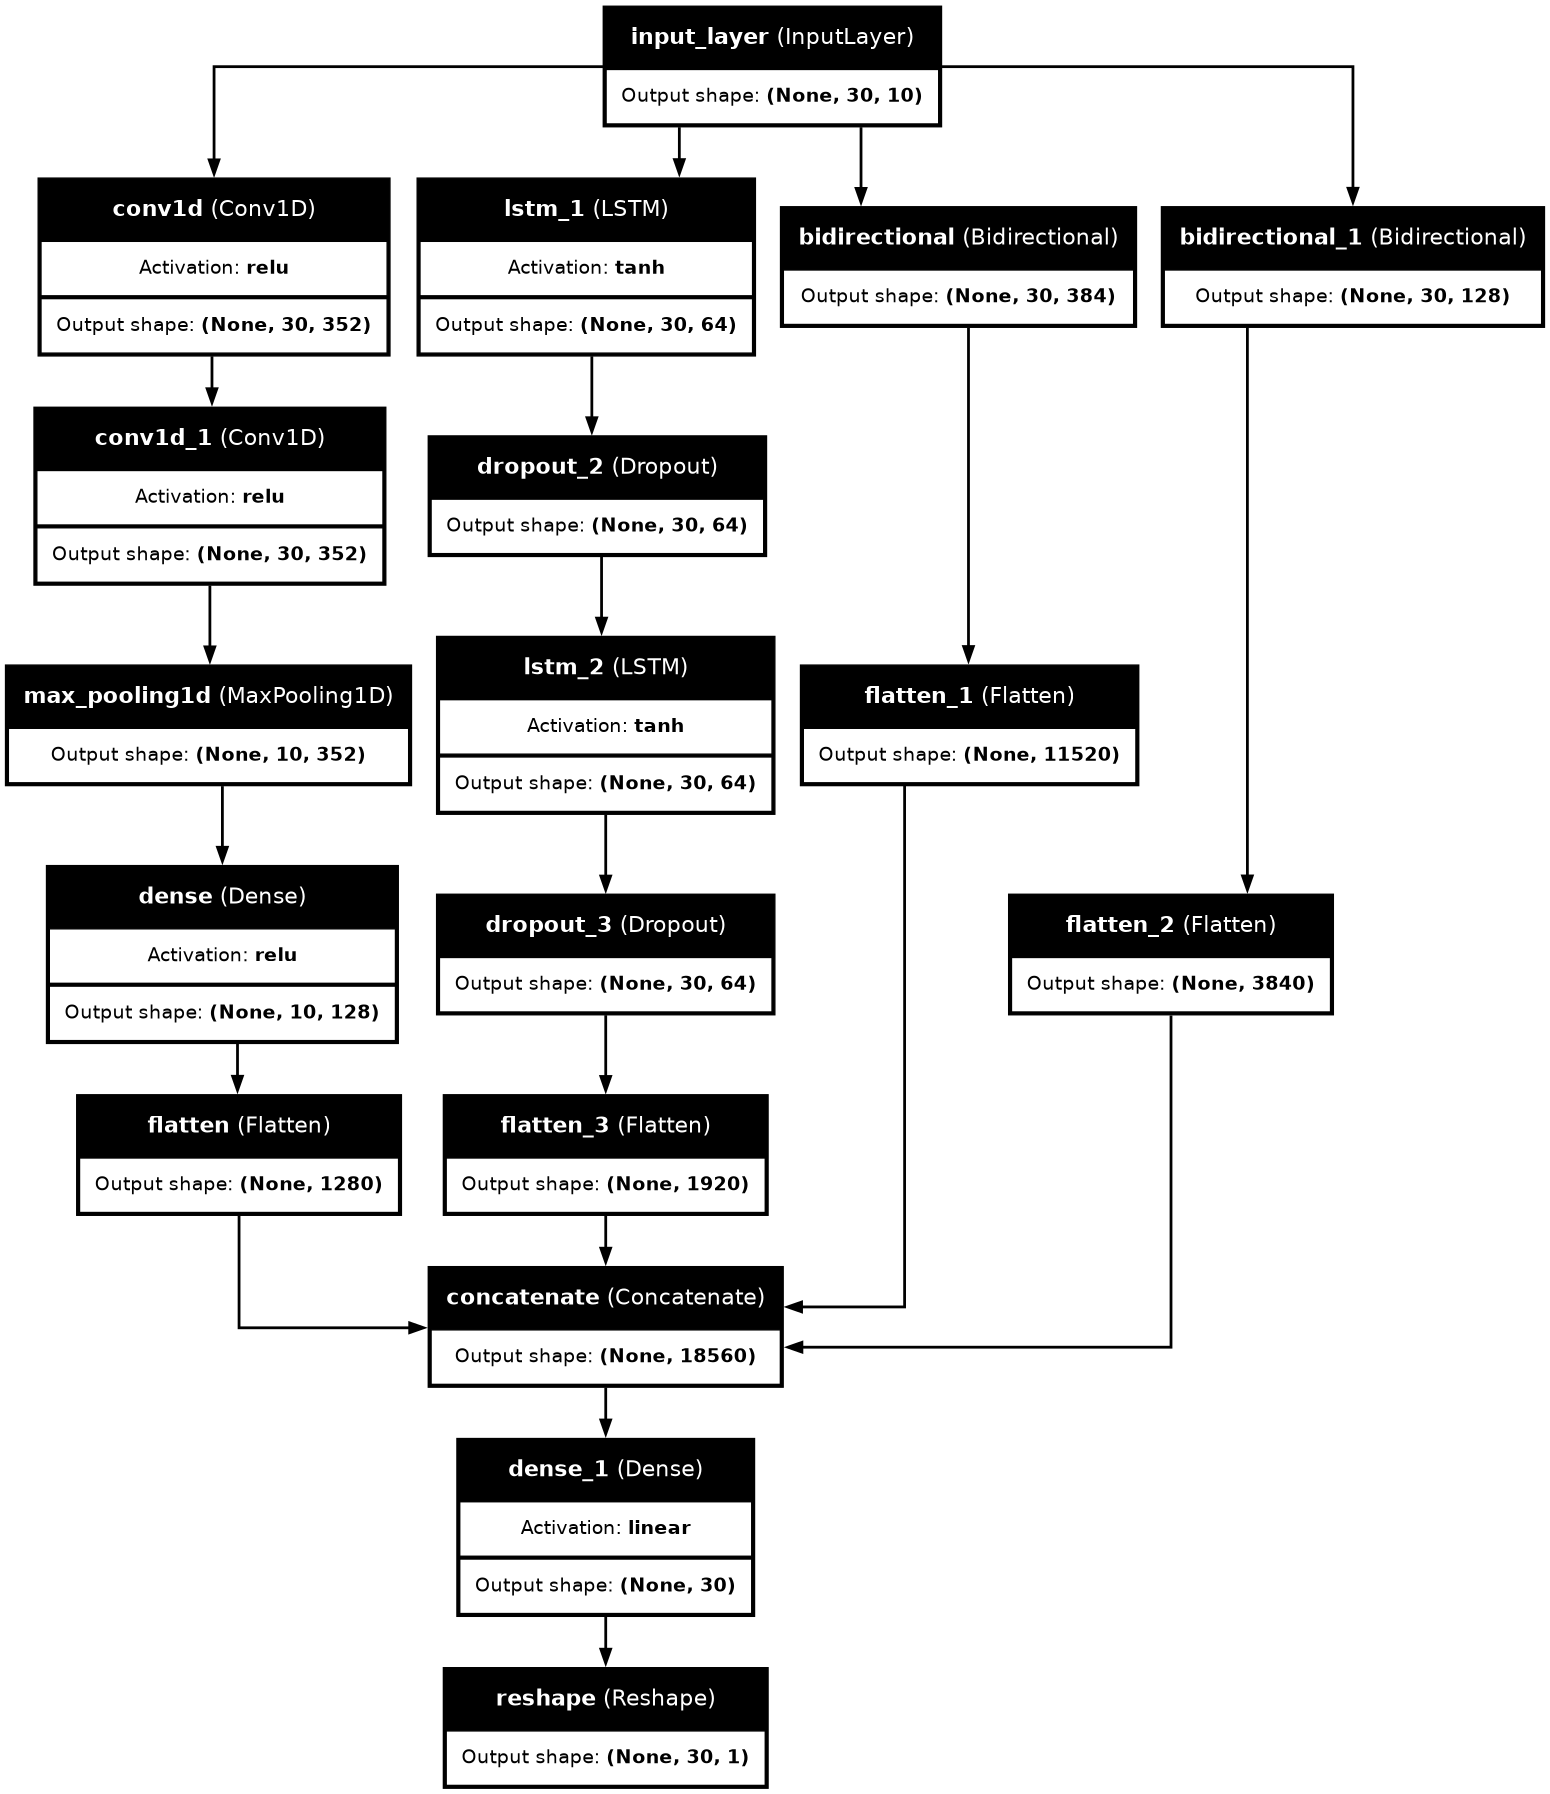

In [103]:
# @title
plot_model(best_model, to_file = 'proposed_demand_forecasting_model.png', show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [104]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.9627 - mean_absolute_error: 3.9485 - mean_absolute_percentage_error: 20.9315 - mean_squared_error: 23.8864 - root_mean_squared_error: 4.8827


{'loss': 23.361244201660156,
 'mean_absolute_error': 3.9064812660217285,
 'mean_absolute_percentage_error': 21.376752853393555,
 'mean_squared_error': 22.941598892211914,
 'root_mean_squared_error': 4.78973913192749}

In [105]:
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.5924 - mean_absolute_error: 3.9052 - mean_absolute_percentage_error: 18.6232 - mean_squared_error: 22.5305 - root_mean_squared_error: 4.7448
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


{'loss': 23.024051666259766,
 'mean_absolute_error': 3.9377262592315674,
 'root_mean_squared_error': 4.798338413238525,
 'mean_absolute_percentage_error': 19.754358291625977,
 'mean_squared_error': 23.024051666259766}

In [106]:
score

{'loss': 23.728694915771484,
 'mean_absolute_error': 3.9991157054901123,
 'mean_absolute_percentage_error': 20.15753936767578,
 'mean_squared_error': 23.573829650878906,
 'root_mean_squared_error': 4.855288505554199}

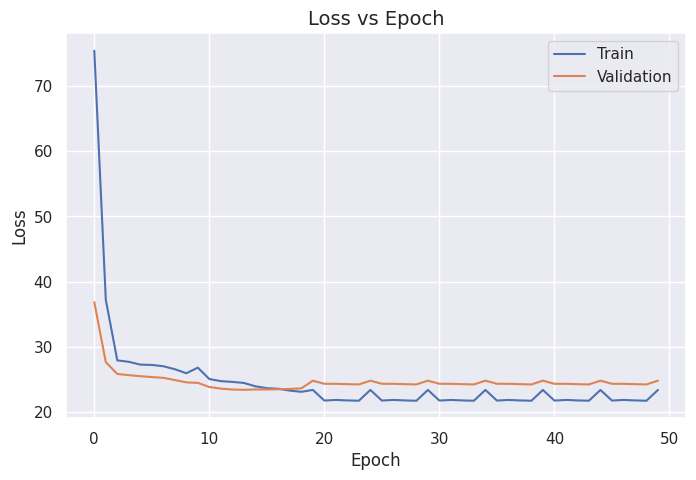

In [134]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_bilstm_loss.png", dpi=300)
plt.show()

Evaluation for Feature 1:
Mean Squared Error: 23.573827743530273
Mean Absolute Error: 3.9991159439086914


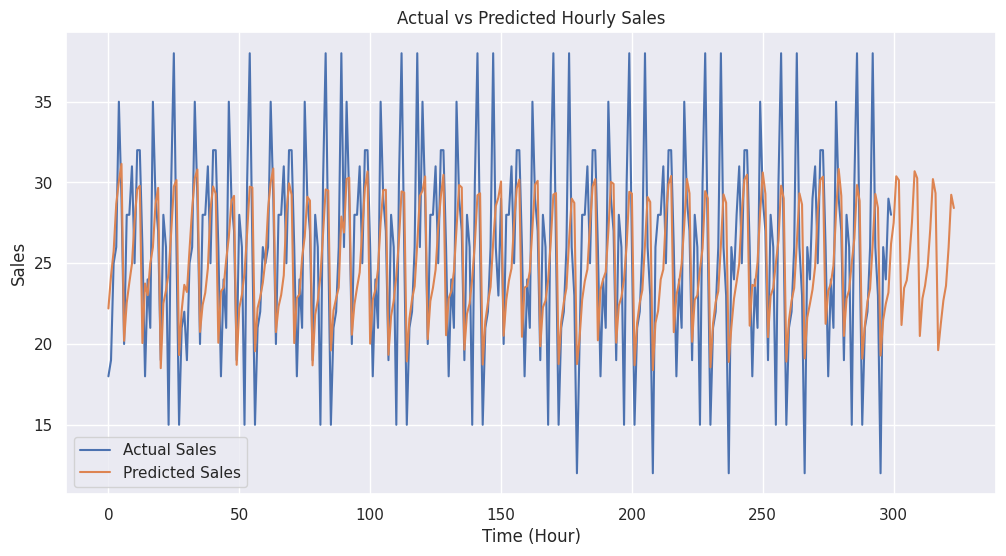

In [108]:
# Extract the actual values from the test dataset
actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot_feature(y_test, y_pred, feature_index):
    # Extract the specified feature from y_pred
    y_pred_feature = y_pred[:, :, feature_index]

    # Reshape y_pred_feature to match the shape of y_test
    y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

    # Flatten both y_test and y_pred_feature for evaluation
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_feature_reshaped.flatten()

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)

    print(f'Evaluation for Feature {feature_index + 1}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))

    # Plotting actual values
    plt.plot(y_test_flat[:300], label='Actual Sales')

    # Plotting predicted values
    plt.plot(y_pred_flat[:324], label=f'Predicted Sales')

    plt.title(f'Actual vs Predicted Hourly Sales')
    plt.xlabel('Time (Hour)')
    plt.ylabel(f'Sales')
    plt.legend()
    plt.show()

# Assuming y_test has shape (136, 24, 1) and y_pred has shape (136, 24, 10)

feature_index_to_evaluate = 0  # Adjust the feature index you want to evaluate
evaluate_and_plot_feature(actual_values, y_pred, feature_index_to_evaluate)


In [109]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.2990302
Mean p-value: 0.20307085


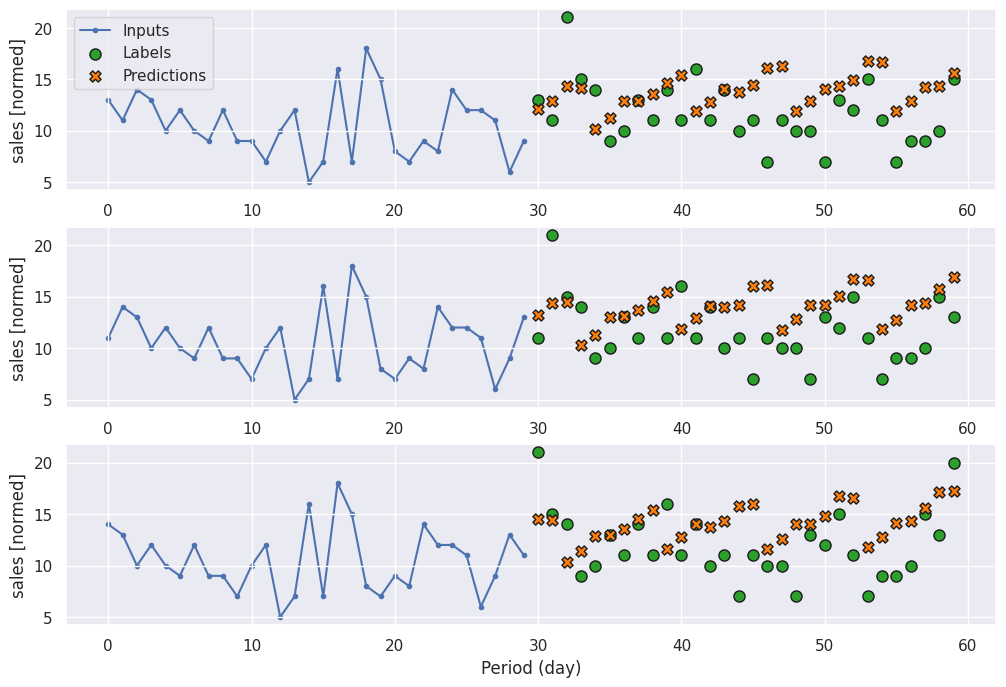

In [110]:
single_step_window.plot(best_model)

## CNN-LSTM-Parallel

In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential


# Create a Sequential model
model = Sequential()

# Add the input layer
inputs = Input(shape=(OUT_STEPS, 10), name='input_layer')  # Adjusted input shape

#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))

# first input model
# Convolutional Layers
out1 = tf.keras.layers.Conv1D(filters=512, kernel_size=3, strides=1)(inputs) #16
out1 = tf.keras.layers.BatchNormalization()(out1)
for _ in range(5):
    out = tf.keras.layers.Conv1D(filters=128, kernel_size=4, strides=1, padding='same')(out1) #32
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Activation("relu")(out)
    out = tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding='same')(out) #16
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Concatenate()([out, out1])
    out = tf.keras.layers.Activation("relu")(out)
    out1 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(out)

#out1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu'))(out1) # 60
cnn1 = tf.keras.layers.Flatten()(out1)
cnn1 = tf.keras.layers.Dense(480, activation="relu")(cnn1)
#cnn1 = tf.keras.layers.Dense(OUT_STEPS*num_features, activation="relu")(cnn1) #60

# second input model
x0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(inputs)
x = tf.keras.layers.Concatenate(axis=2)([inputs, x0])
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Concatenate(axis=2)([x0, x1])
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
l5 = tf.keras.layers.Concatenate(axis=2)([x0, x1, x2])

lstm1 = tf.keras.layers.Dense(512, activation="relu")(l5) #128
lstm1 = tf.keras.layers.Dropout(0.2)(lstm1)  # Dropout added after LSTM
lstm1 = tf.keras.layers.Dense(1)(lstm1) ## 1
lstm1 = tf.keras.layers.Flatten()(lstm1)

# Merge input models
merge = Concatenate()([cnn1, lstm1])
merge = tf.keras.layers.Dropout(0.2)(merge)
#dense = Dense(128, activation="relu")(merge) #128
output = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(merge)
output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(output)

model = tf.keras.models.Model(inputs=[inputs], outputs=output)


# Compile the model
learning_rate = 1e-4  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#acc = tf.keras.metrics.RootMeanSquaredError()

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()],
    optimizer=optimizer
)

# Build the model.
model.summary()

Model: "model_1"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_layer (InputLayer)    [(None, 30, 10)]             0         []                            

                                                                                                  

 conv1d_1 (Conv1D)           (None, 28, 512)              15872     ['input_layer[0][0]']         

                                                                                                  

 batch_normalization (Batch  (None, 28, 512)              2048      ['conv1d_1[0][0]']            

 Normalization)                                                                                   

                                                                                                  

 conv1d_2 (Conv1D)           (None, 28, 128)              262272    ['batch_norma

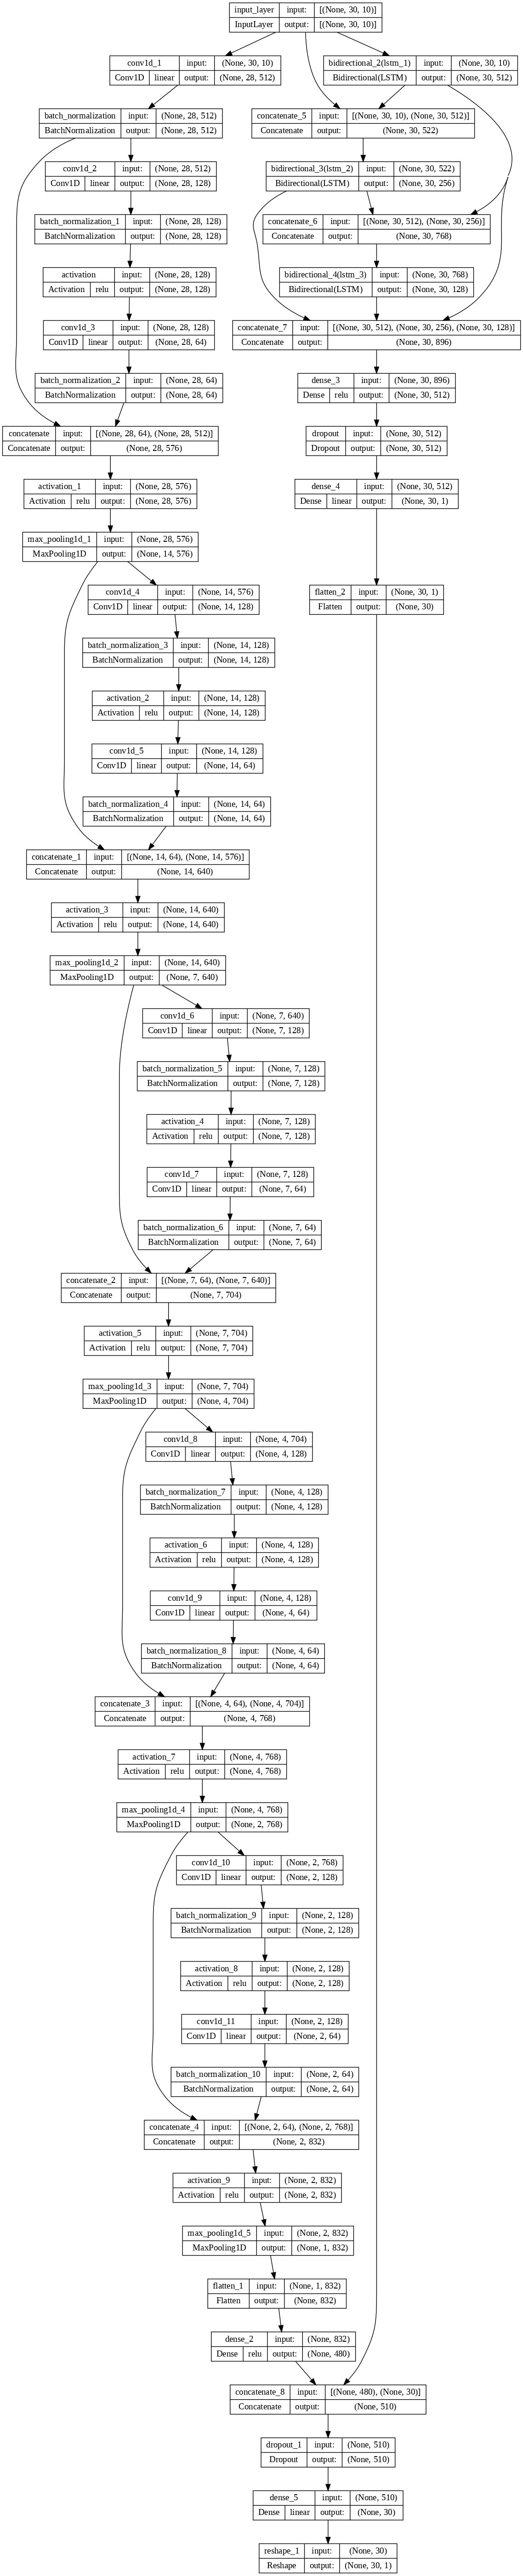

In [ ]:
# @title
#model = best_model
tf.keras.utils.plot_model(model, to_file = 'timeseries_model.png', show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
# @title
# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)

class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')

hist7 = model.fit(
    single_step_window.train,
    batch_size=32,
    epochs = 50,
    #verbose=2,
    callbacks=[checkpoint, early_stop],
    #callbacks=[lr_reducer],
    shuffle=False,
    validation_data=single_step_window.val,
)

Epoch 1/50

39/39 [==============================] - ETA: 0s - loss: 270.9215 - mean_absolute_error: 15.0941 - root_mean_squared_error: 16.4597 - mean_absolute_percentage_error: 78.0163 - mean_squared_error: 270.9215

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


39/39 [==============================] - 27s 148ms/step - loss: 270.9215 - mean_absolute_error: 15.0941 - root_mean_squared_error: 16.4597 - mean_absolute_percentage_error: 78.0163 - mean_squared_error: 270.9215 - val_loss: 191.5435 - val_mean_absolute_error: 12.4589 - val_root_mean_squared_error: 13.8399 - val_mean_absolute_percentage_error: 56.0654 - val_mean_squared_error: 191.5436

Epoch 2/50

39/39 [==============================] - 2s 47ms/step - loss: 41.7825 - mean_absolute_error: 5.1546 - root_mean_squared_error: 6.4639 - mean_absolute_percentage_error: 32.9980 - mean_squared_error: 41.7825 - val_loss: 118.5696 - val_mean_absolute_error: 9.2482 - val_root_mean_squared_error: 10.8890 - val_mean_absolute_percentage_error: 40.2715 - val_mean_squared_error: 118.5695

Epoch 3/50

39/39 [==============================] - 3s 75ms/step - loss: 40.2230 - mean_absolute_error: 5.0120 - root_mean_squared_error: 6.3422 - mean_absolute_percentage_error: 31.5736 - mean_squared_error: 40.2230

In [ ]:
model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 12ms/step - loss: 28.9908 - mean_absolute_error: 4.2917 - root_mean_squared_error: 5.3843 - mean_absolute_percentage_error: 23.7009 - mean_squared_error: 28.9908


{'loss': 28.990812301635742,
 'mean_absolute_error': 4.291699409484863,
 'root_mean_squared_error': 5.384311199188232,
 'mean_absolute_percentage_error': 23.700908660888672,
 'mean_squared_error': 28.990808486938477}

In [ ]:
score = model.evaluate(single_step_window.test, return_dict=True)
y_pred = model.predict(single_step_window.test)

4/4 [==============================] - 0s 115ms/step - loss: 32.2743 - mean_absolute_error: 4.5099 - root_mean_squared_error: 5.6810 - mean_absolute_percentage_error: 22.7501 - mean_squared_error: 32.2743

4/4 [==============================] - 2s 17ms/step


In [ ]:
score

{'loss': 32.27431106567383,
 'mean_absolute_error': 4.509872913360596,
 'root_mean_squared_error': 5.68104887008667,
 'mean_absolute_percentage_error': 22.750076293945312,
 'mean_squared_error': 32.274314880371094}

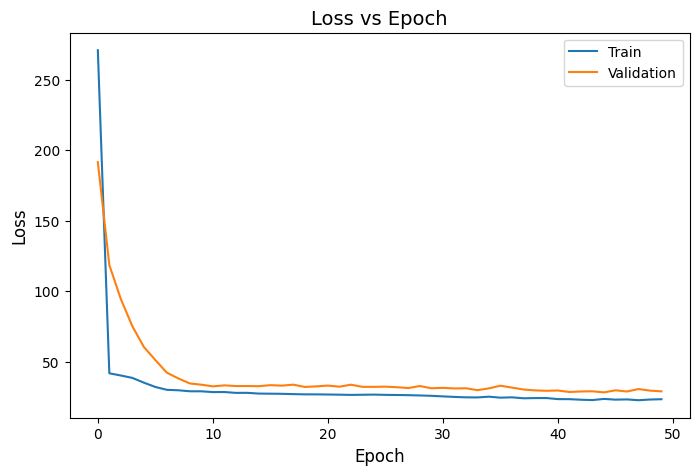

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_bilstm_parallel_loss.png", dpi=300)
plt.show()

Evaluation for Feature 1:

Mean Squared Error: 32.27431106567383

Mean Absolute Error: 4.509872913360596


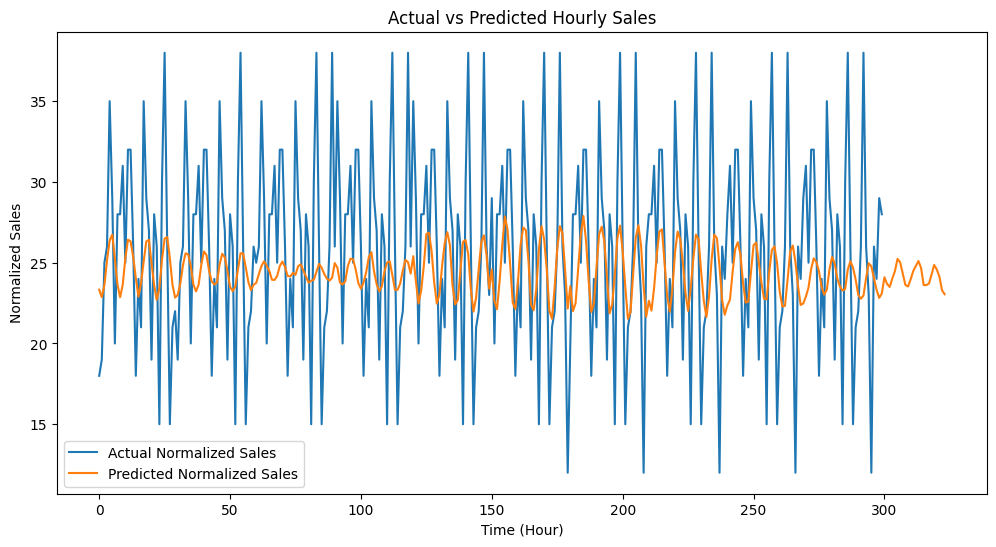

In [ ]:
# Extract the actual values from the test dataset
actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot_feature(y_test, y_pred, feature_index):
    # Extract the specified feature from y_pred
    y_pred_feature = y_pred[:, :, feature_index]

    # Reshape y_pred_feature to match the shape of y_test
    y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

    # Flatten both y_test and y_pred_feature for evaluation
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_feature_reshaped.flatten()

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)

    print(f'Evaluation for Feature {feature_index + 1}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))

    # Plotting actual values
    plt.plot(y_test_flat[:300], label='Actual Normalized Sales')

    # Plotting predicted values
    plt.plot(y_pred_flat[:324], label=f'Predicted Normalized Sales')

    plt.title(f'Actual vs Predicted Hourly Sales')
    plt.xlabel('Time (Hour)')
    plt.ylabel(f'Normalized Sales')
    plt.legend()
    plt.show()

# Assuming y_test has shape (136, 24, 1) and y_pred has shape (136, 24, 10)

feature_index_to_evaluate = 0  # Adjust the feature index you want to evaluate
evaluate_and_plot_feature(actual_values, y_pred, feature_index_to_evaluate)


In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -2.1482387

Mean p-value: 0.19647662


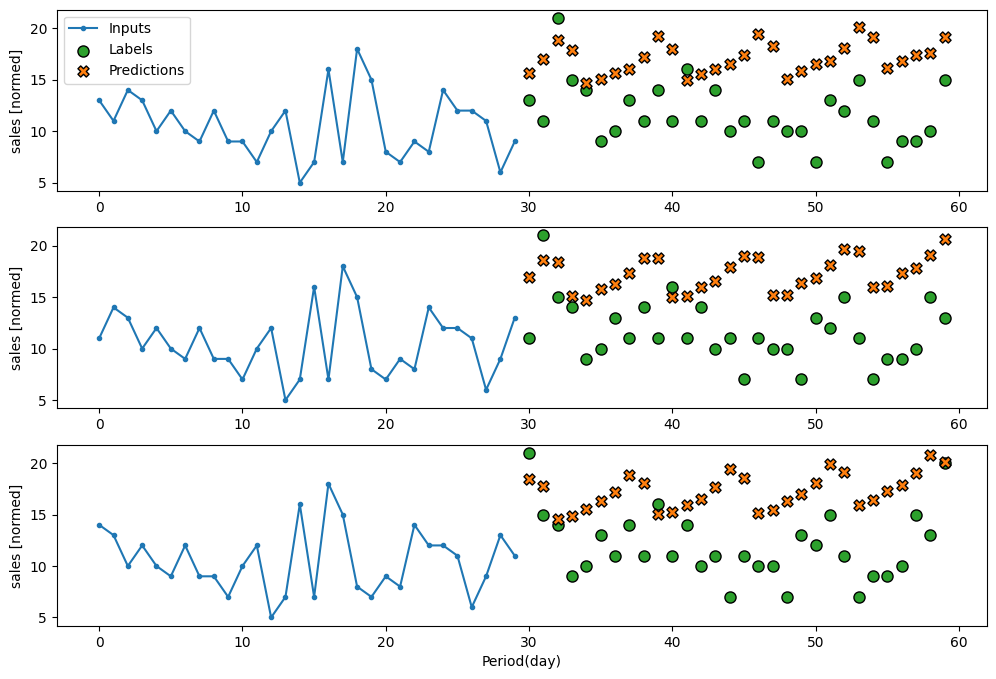

In [ ]:
single_step_window.plot(best_model)